<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/.../Air_Pollution_Prediction/air_pollution_forecast_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

As we enter an era of rapid climate change, the implications for air quality need to be better understood, both for the purpose of air quality management and as one of the societal consequences of climate change. Air is relevant for humans, and since industrialization, there has been an increasing environmental pollution. In the WHO report 7 million premature deaths annually are caused by bad environment conditions, so air pollution is the world's largest single environmental risk. Monitoring and understanding air quality is crucial for health and climate change. This job has followed the aim to explore hourly air quality Index (AQI) data in India with a data set coming from Kaggle. The first approach was to apply an Exploratory Data Analysis by the use of statistics, time series visualization charts, rolling window and decomposition. After the data preparation activity with outliers imputation and feature engineering, the forecasting and features importance has done using several models.

![](https://www.nps.gov/subjects/air/images/Sources_Graphic_Huge.jpg)

### Prepare workspace

In [1]:
! pip install feature_engine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 6.1 MB/s eta 0:00:00


In [2]:
! pip install hampel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 119.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 118.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3

In [4]:
! pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=be3f513372a7cba6500fc23f2cc77de3fdf5e516b3a51528386384441c9689be
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import datetime
import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from feature_engine.timeseries.forecasting import WindowFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from hampel import hampel
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load data set

In [6]:
from google.colab import files 
uploaded = files.upload()

Saving air-quality-india.csv to air-quality-india.csv


In [7]:
df = pd.read_csv('air-quality-india.csv',
                index_col=0,
                parse_dates=True)

### Have a look of the data set

In [8]:
print(df.shape)

(36192, 5)


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36192 entries, 2017-11-07 12:00:00 to 2022-06-04 15:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    36192 non-null  int64  
 1   Month   36192 non-null  int64  
 2   Day     36192 non-null  int64  
 3   Hour    36192 non-null  int64  
 4   PM2.5   36192 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 1.7 MB
None


In [10]:
print(df.columns)

Index(['Year', 'Month', 'Day', 'Hour', 'PM2.5'], dtype='object')


In [11]:
print(df.head())

                     Year  Month  Day  Hour   PM2.5
Timestamp                                          
2017-11-07 12:00:00  2017     11    7    12   64.51
2017-11-07 13:00:00  2017     11    7    13   69.95
2017-11-07 14:00:00  2017     11    7    14   92.79
2017-11-07 15:00:00  2017     11    7    15  109.66
2017-11-07 16:00:00  2017     11    7    16  116.50


### Data Cleaning

In [12]:
# Delete duplicate columns
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

(36192, 5)


In [13]:
# Delete duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

(36192, 5)


In [14]:
# Check missing values 
missing = df.isnull().sum()/df.shape[0]*100
missing

Year     0.0
Month    0.0
Day      0.0
Hour     0.0
PM2.5    0.0
dtype: float64

In [15]:
df.index.min()

Timestamp('2017-11-07 12:00:00')

In [16]:
df.index.max()

Timestamp('2022-06-04 15:00:00')

In [17]:
# formatting features
df.index = pd.to_datetime(df.index)

### Summary Statistics

In [18]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
obj_cols

[]

In [19]:
# Summarize attribute distributions for data type of variables
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
df[num_cols].describe().T

count         mean        std      min      25%      50%      75%  \
Year   36192.0  2019.682278   1.345011  2017.00  2019.00  2020.00  2021.00   
Month  36192.0     6.331841   3.593321     1.00     3.00     6.00    10.00   
Day    36192.0    15.716401   8.859769     1.00     8.00    16.00    23.00   
Hour   36192.0    11.477840   6.925088     0.00     5.00    11.00    17.00   
PM2.5  36192.0    49.308429  24.863511     7.02    28.08    45.73    64.52   

           max  
Year   2022.00  
Month    12.00  
Day      31.00  
Hour     23.00  
PM2.5   245.63

In [20]:
df1 = df.copy()

### Functions

Are prepared some functions for the data visualization and data evaluation

In [21]:
# Vis Chart
def plot_num(data, var):
    plt.rcParams['figure.figsize']=(20,15)
    plt.suptitle('Air Pollution Exploratory Data Analysis',fontsize=25)
    plt.subplot(2,2,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(2,2,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(2,2,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.xticks(rotation=45)
    
    plt.subplot(2,2,4)
    # autocorrelation plot 
    autocorrelation_plot(df[var])
    plt.title("{} vs time autocorrelation".format(var)) 
    
    plt.show()

In [22]:
def barplot(data, var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['PM2.5'].mean()
    df.plot.bar(color='blue')
    plt.suptitle('Distribution PM2.5 per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=20)
    plt.ylabel('PM2.5', fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()

In [23]:
# Vis Chart
def barplot2(data, var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['PM2.5'].count()
    df.plot.bar(color='blue')
    plt.suptitle('Distribution PM2.5 observations per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=15)
    plt.ylabel('count PM2.5', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    plt.show()

In [24]:
def lineplot(data,var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['PM2.5'].mean()
    df.plot(color='blue', linewidth=5)
    plt.suptitle('Distribution PM2.5 per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=20)
    plt.ylabel('PM2.5', fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show() 

In [25]:
def tsplot(data,var,period):
    plt.rcParams['figure.figsize']=(20,10)
    if period=='all':
        plt.plot(data[var], linewidth=3, color='Orange')
    else:
        plt.plot(data[var].loc[period], linewidth=3,color='Orange') 
    plt.suptitle('Air Pollution Time Series',fontsize=25)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('{}'.format(var), fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()

In [26]:
def tsmultiplot(data,period):
    plt.rcParams['figure.figsize']=(20,10)
    if period=='all':
        plt.plot(data, linewidth=3)
    else:
        plt.plot(data.loc[period], linewidth=3) 
    my_labels=['PM2.5_Actual', 'PM2.5_Prediction']
    plt.suptitle('Air Pollution Time Series: Actual vs Prediction',fontsize=25)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Actual vs Prediction',fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.legend(my_labels,fontsize=20)
    plt.show()

In [27]:
# Evaluation function
def evaluate(model, X, y, cv):
    def score_func(estimator, X, y):
        y_pred = estimator.predict(X)
        return {
            "root_mean_squared_error": np.sqrt(mean_squared_error(y, y_pred)),
            "mean_absolute_error": mean_absolute_error(y, y_pred),
        }
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=score_func,
        return_train_score=True
    )
    
    print('Train evaluation')
    for key, value in cv_results.items():
        if key.startswith("train_"):
            print(f"{key[6:]}: {value.mean():.3f} ± {value.std():.3f}")
 
    print('Test evaluation')
    for key, value in cv_results.items():
        if key.startswith("test_"):
            print(f"{key[5:]}: {value.mean():.3f} ± {value.std():.3f}")

### Target Variable Analysis

Looking at the series, it follows a right skewed distribution, it shows outliers, high autocorrelation, and a cyclic behaviour over time. Data are not equally distribuited over the period, there are inconsistent obervations at the the first year and at the last year of the series.

In [28]:
# Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
print('\nMean :', np.mean(df1['PM2.5']),  
        '\nVariance :', np.var(df1['PM2.5']),
        '\nStandard Deviation :', np.var(df1['PM2.5']**0.5), 
        '\nSkewness :', stats.skew(df1['PM2.5']), 
        '\nKurtosis :', stats.kurtosis(df1['PM2.5']))


Mean : 49.30842865826703 
Variance : 618.1770838234361 
Standard Deviation : 3.0028819077034066 
Skewness : 0.9155939213111379 
Kurtosis : 1.1211328273139296


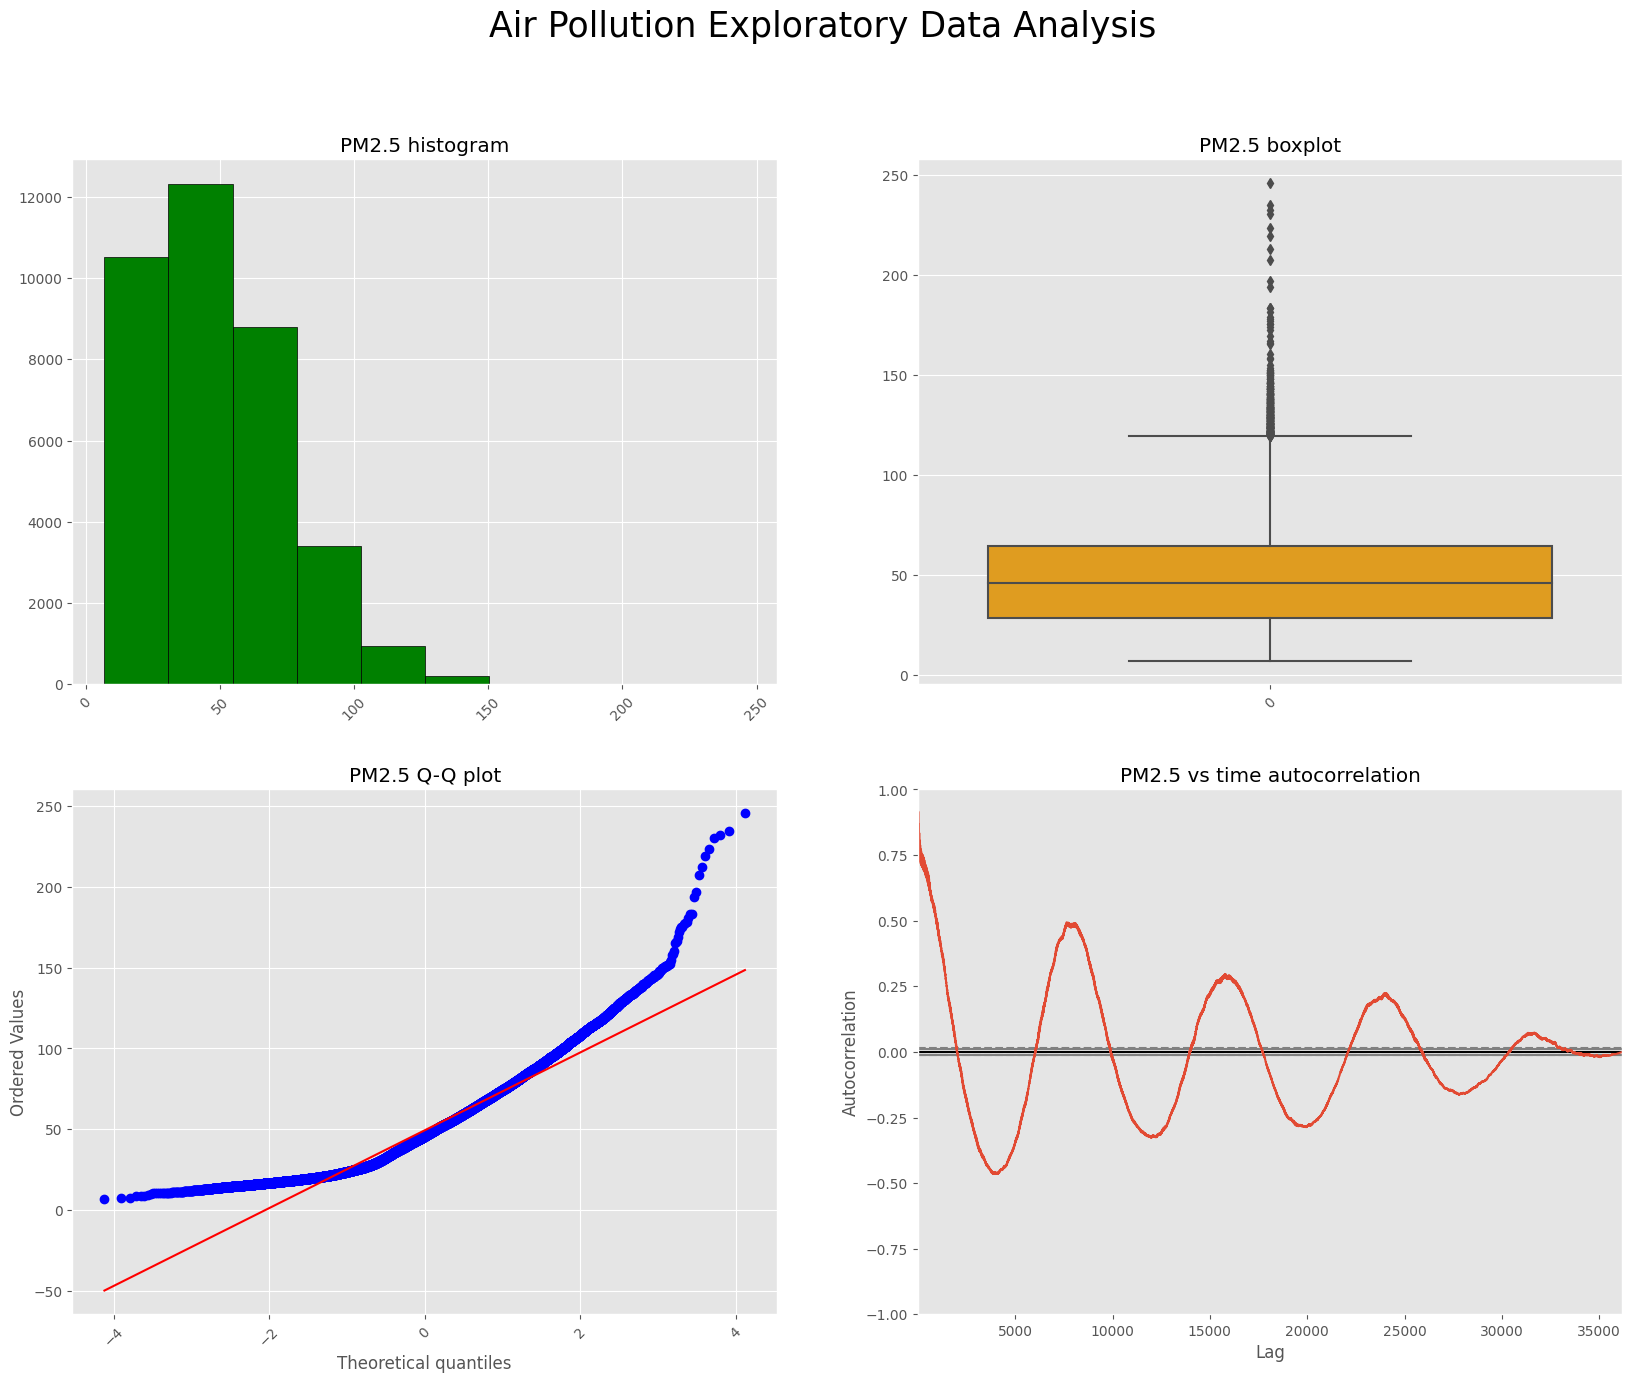

In [29]:
# Target variable visualization
plot_num(df1, var='PM2.5')

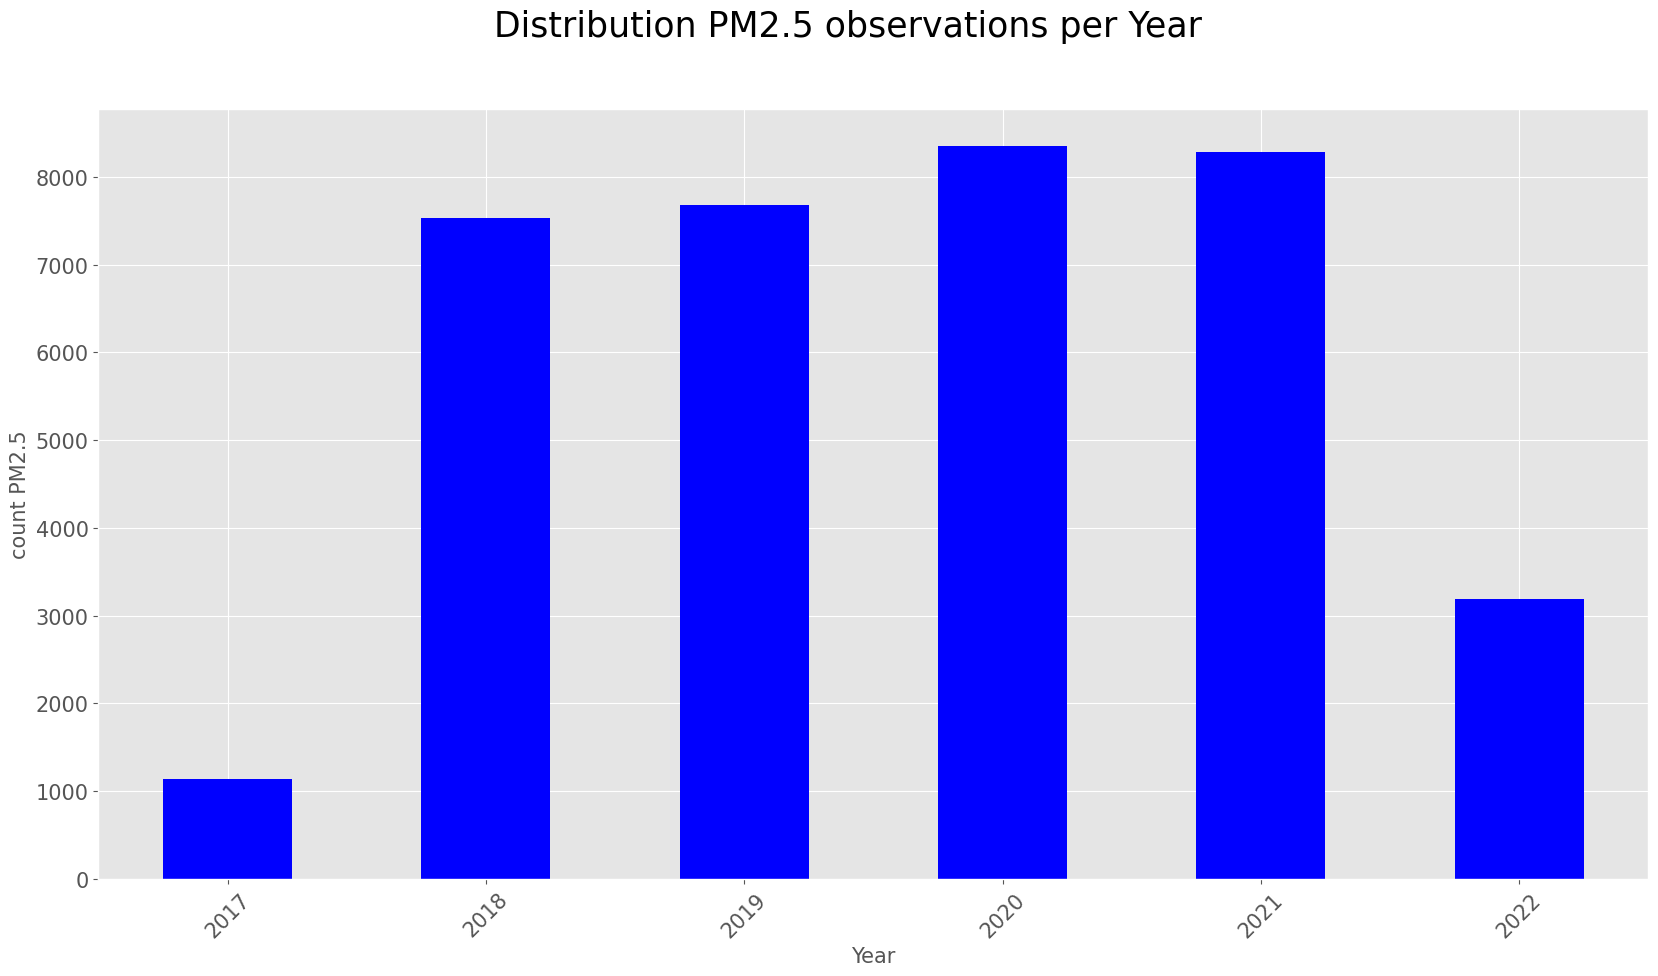

In [30]:
# Count observations per year
barplot2(df1,'Year')

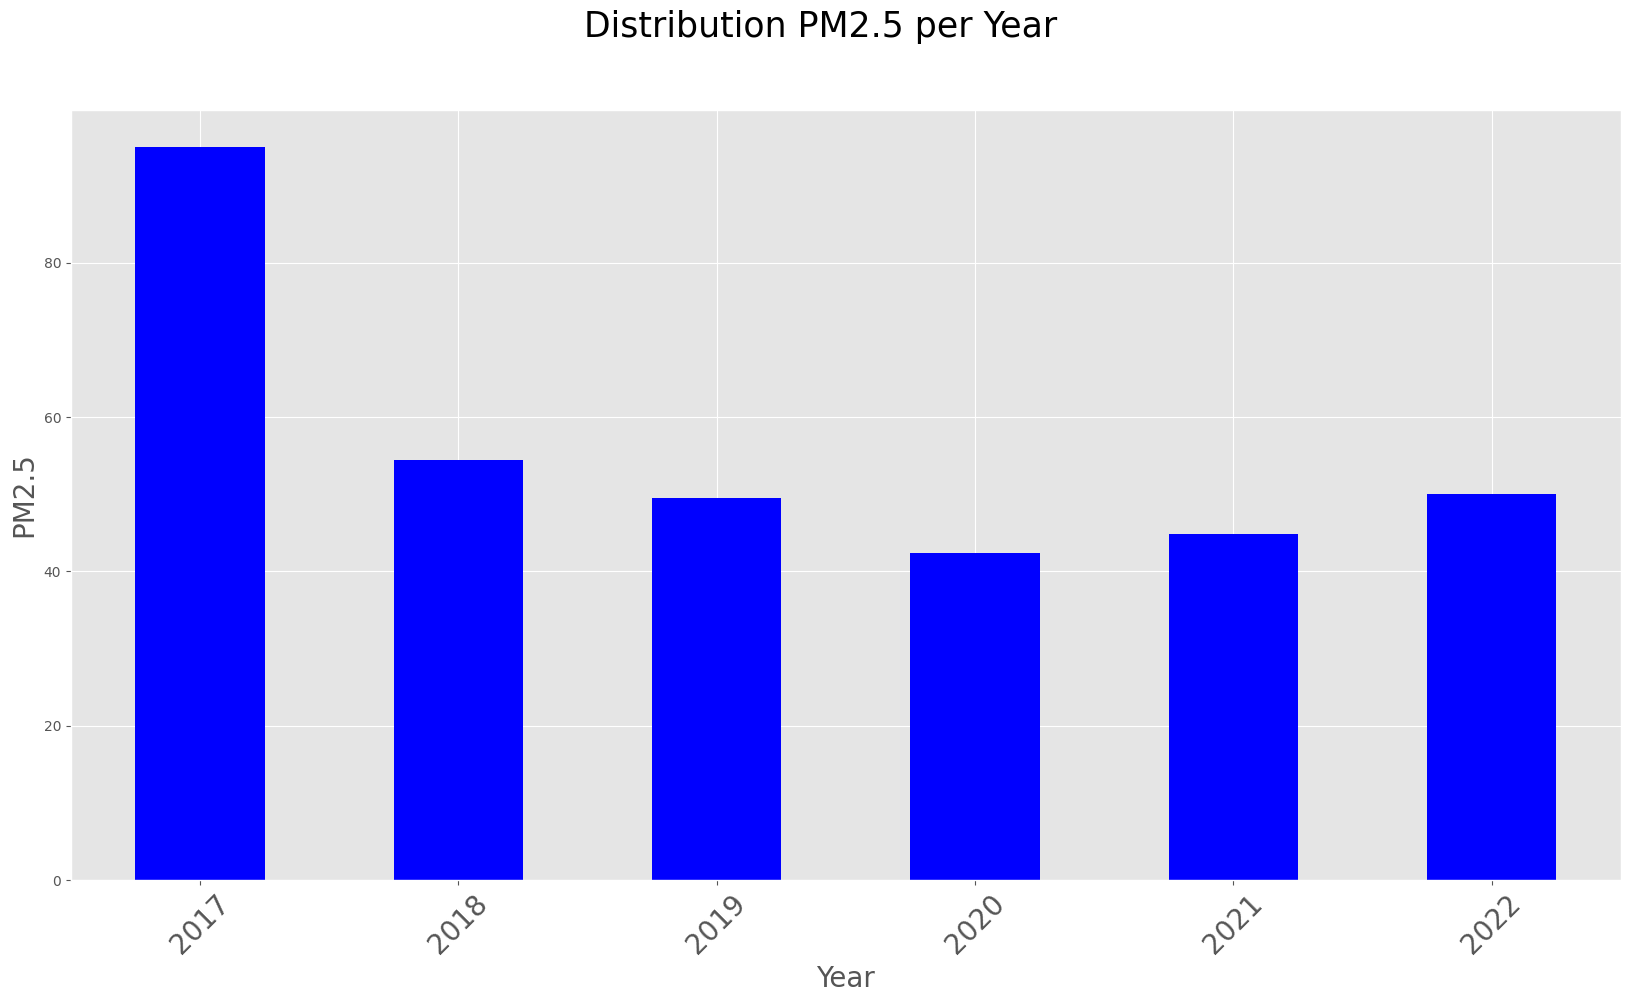

In [31]:
# Target variable distribution per year
barplot(df1, var='Year')

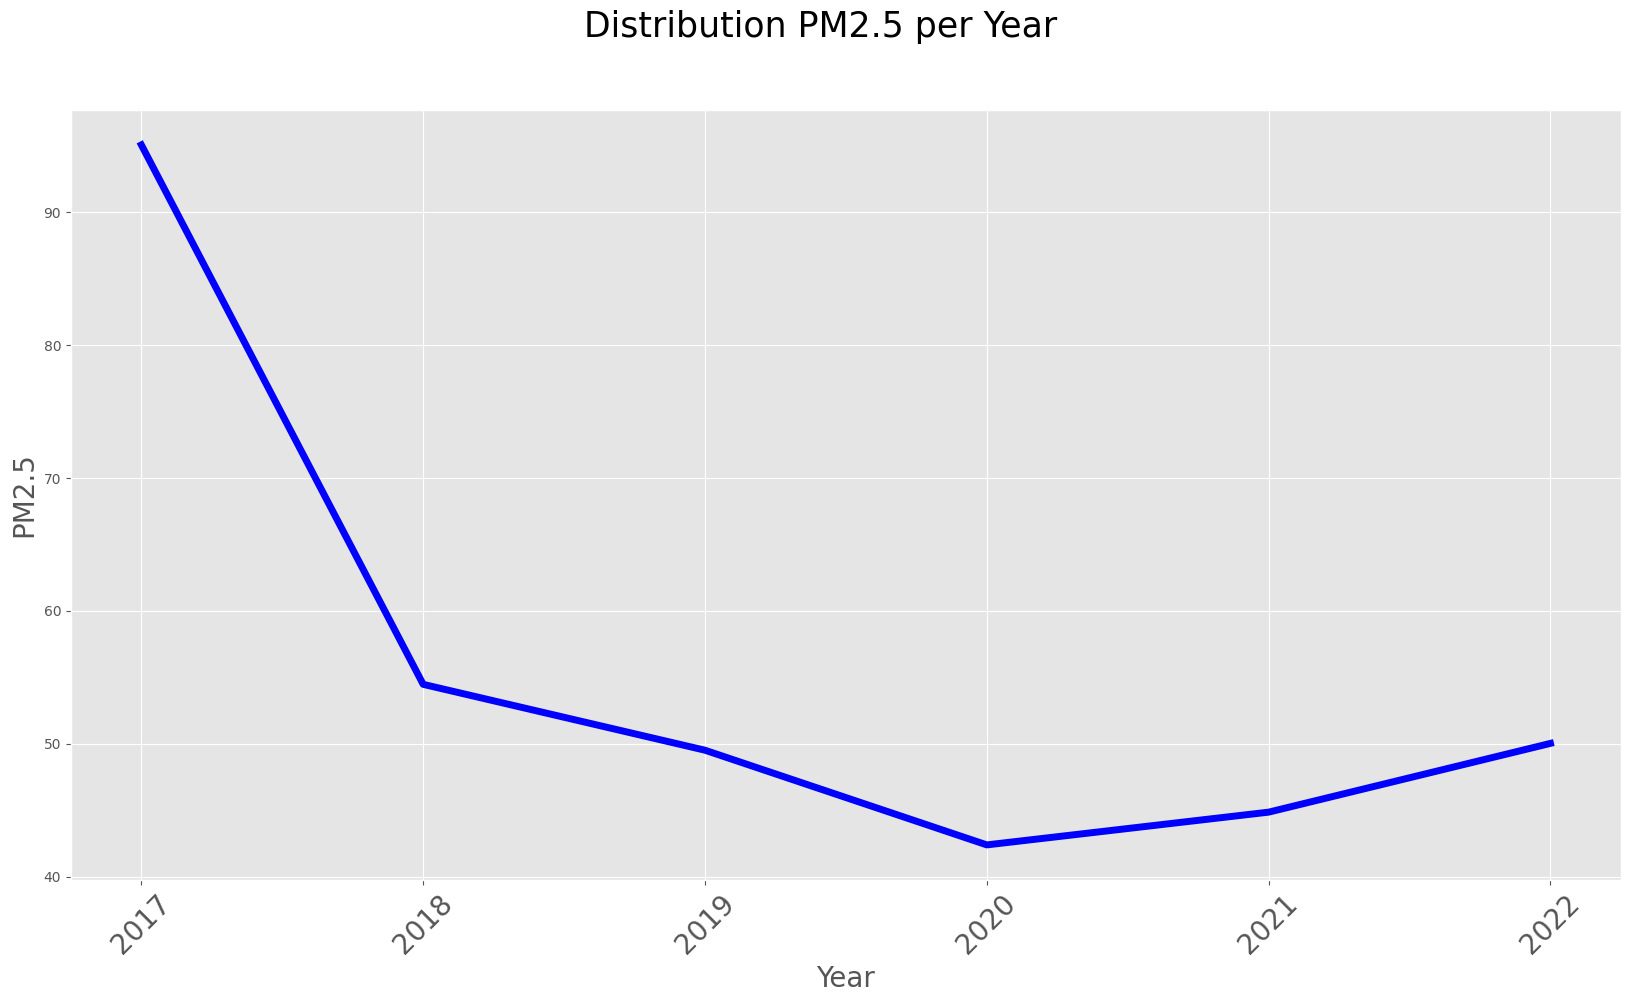

In [32]:
lineplot(df1,'Year')

In [33]:
df1.groupby(df1['Year'])['PM2.5'].mean()

Year
2017    95.064160
2018    54.468449
2019    49.511273
2020    42.386302
2021    44.850633
2022    50.025717
Name: PM2.5, dtype: float64

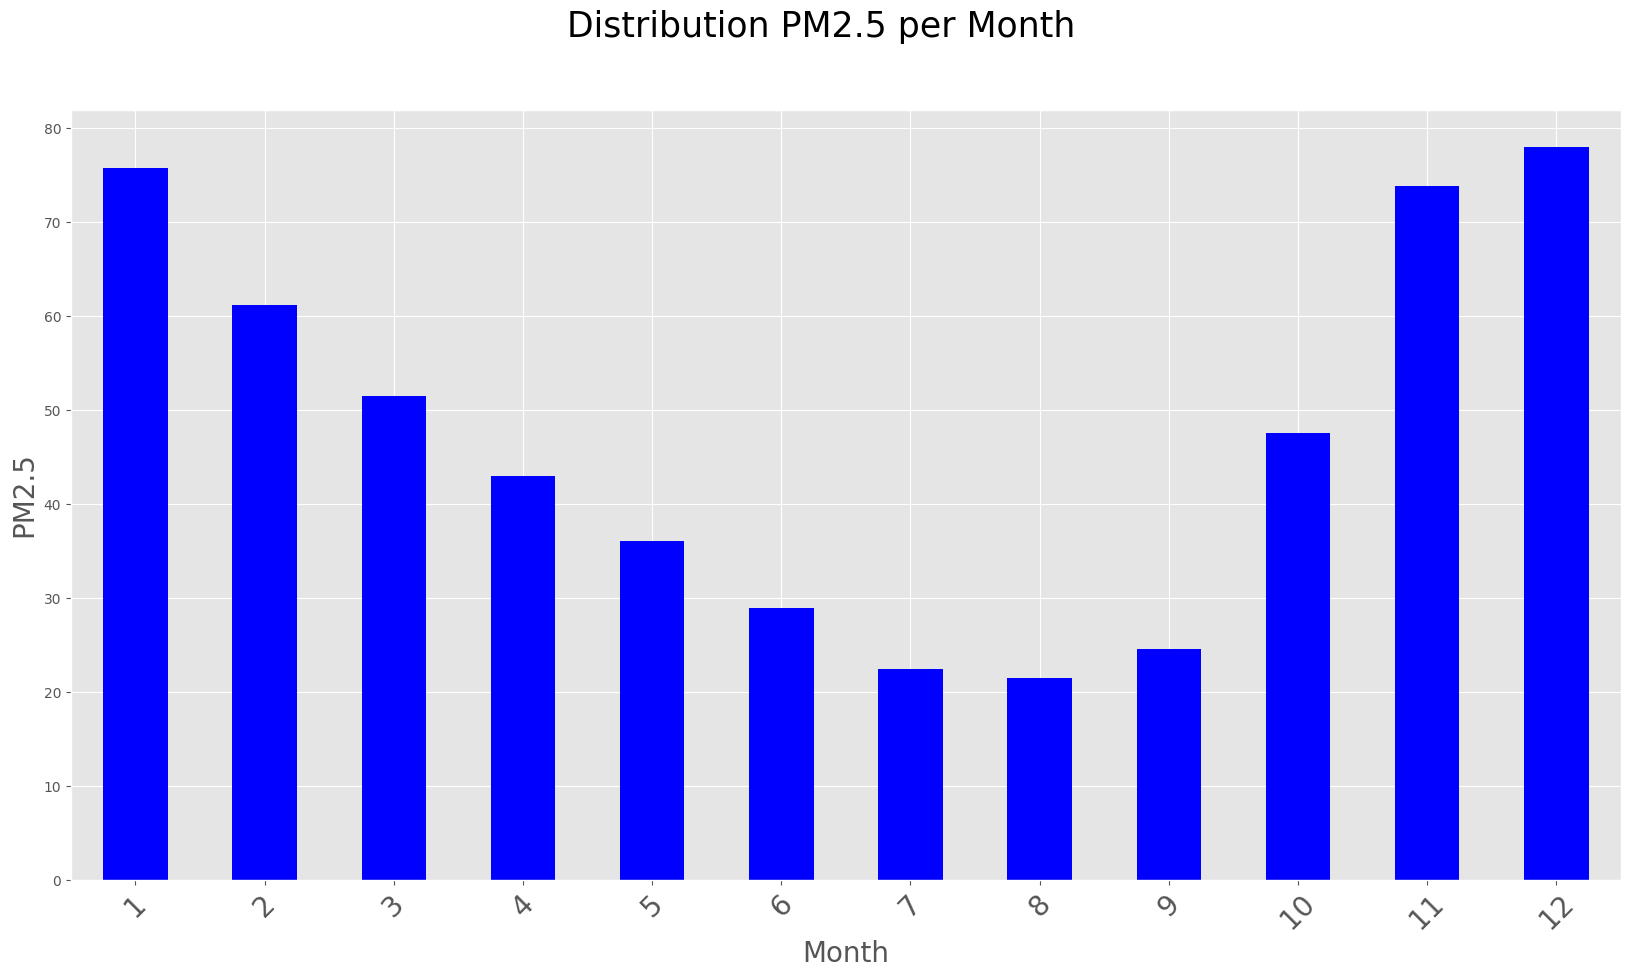

In [34]:
# Target variable distribution per month
barplot(df1, var='Month')

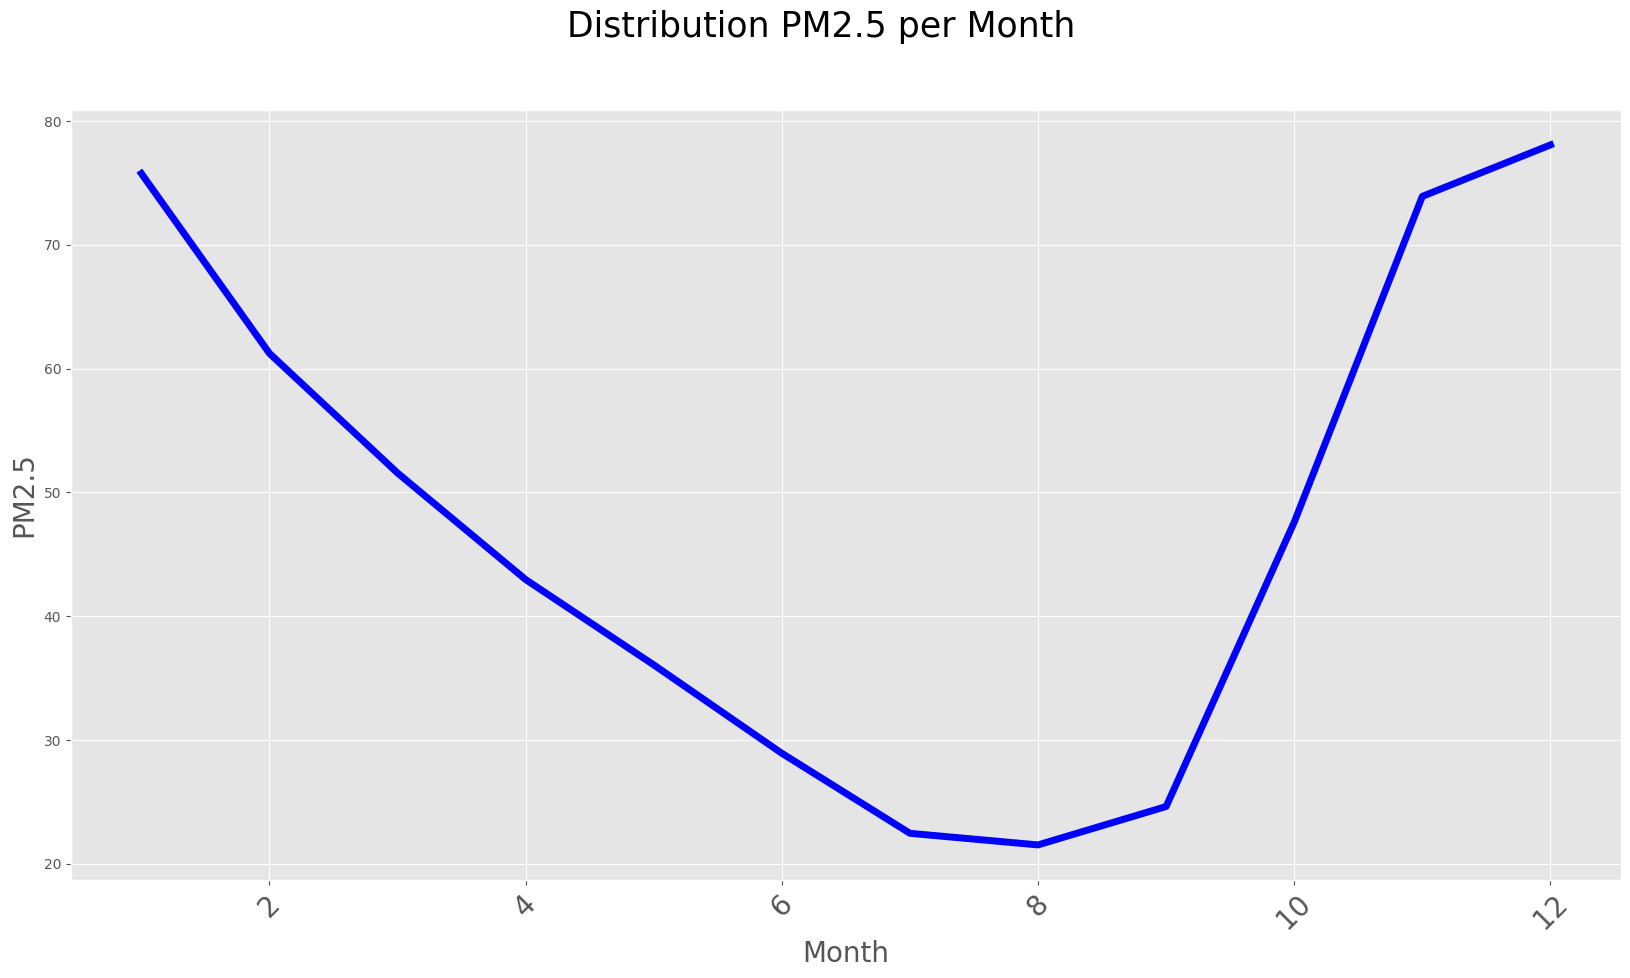

In [35]:
lineplot(df1,'Month')

In [36]:
df1.groupby(df1['Month'])['PM2.5'].mean()

Month
1     75.762716
2     61.233323
3     51.568116
4     42.961583
5     36.068882
6     28.926157
7     22.461443
8     21.525650
9     24.627094
10    47.602640
11    73.918083
12    78.073387
Name: PM2.5, dtype: float64

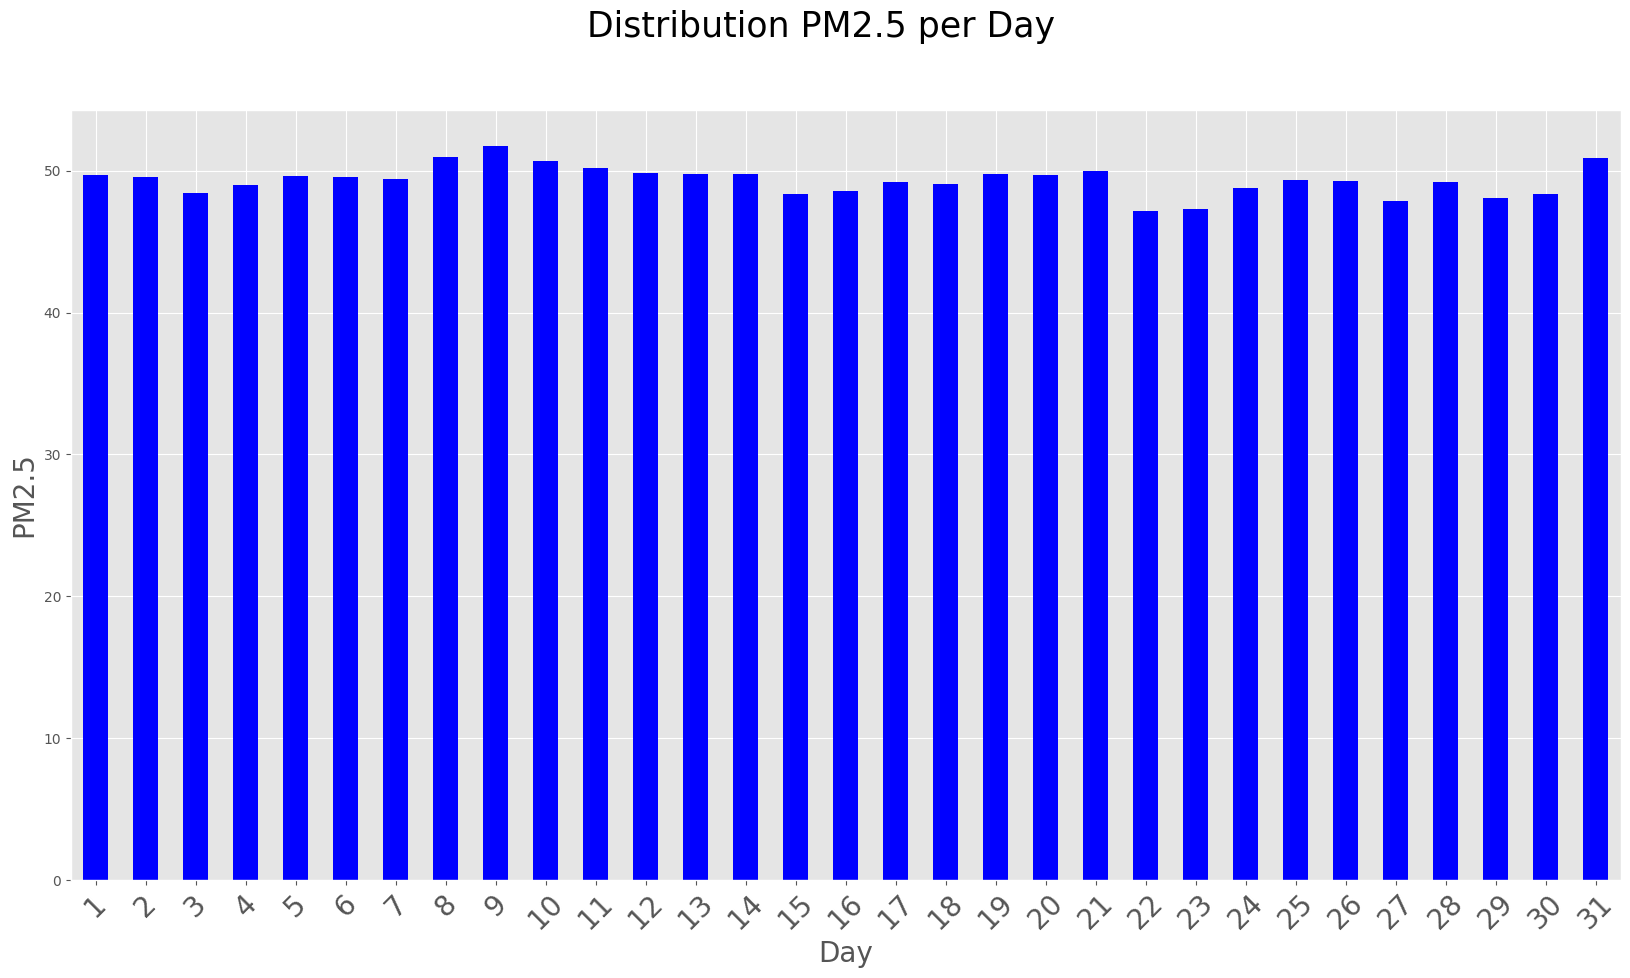

In [37]:
# Target variable distribution per day
barplot(df1, var='Day')

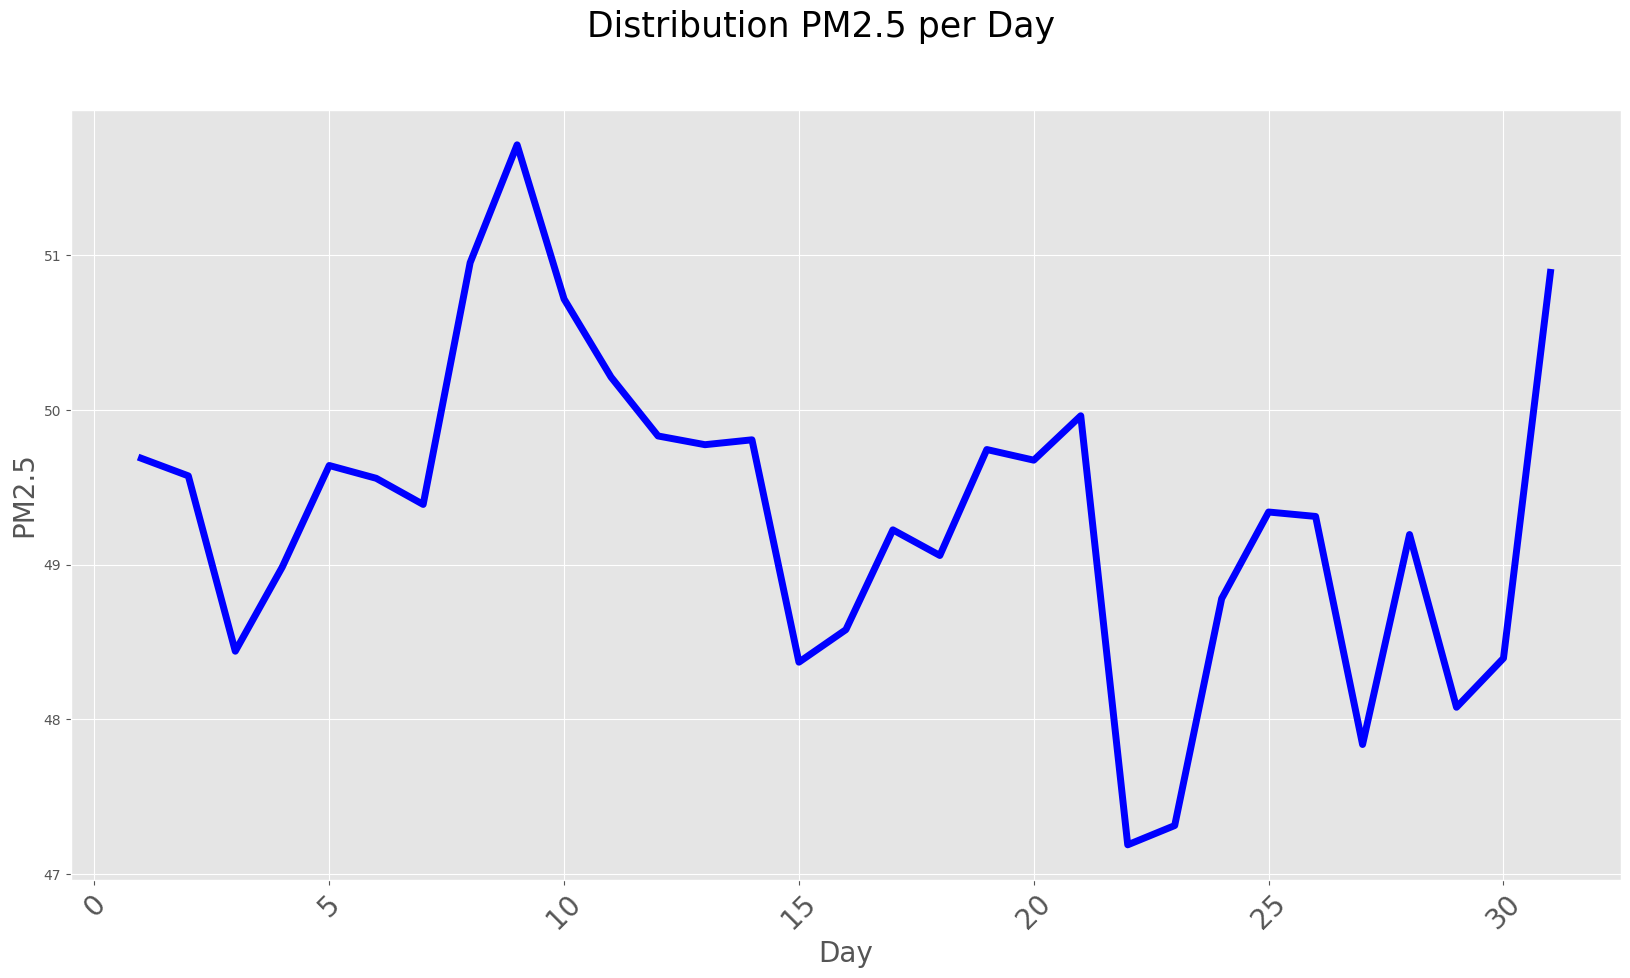

In [38]:
lineplot(df1,'Day')

In [39]:
df1.groupby(df1['Day'])['PM2.5'].mean()

Day
1     49.687282
2     49.573699
3     48.440537
4     48.984712
5     49.640774
6     49.558032
7     49.389150
8     50.951376
9     51.713174
10    50.716523
11    50.212031
12    49.831619
13    49.775209
14    49.806715
15    48.369617
16    48.579875
17    49.224871
18    49.059259
19    49.743947
20    49.675198
21    49.962021
22    47.189337
23    47.313795
24    48.780457
25    49.340100
26    49.311593
27    47.837704
28    49.194572
29    48.078250
30    48.395346
31    50.888586
Name: PM2.5, dtype: float64

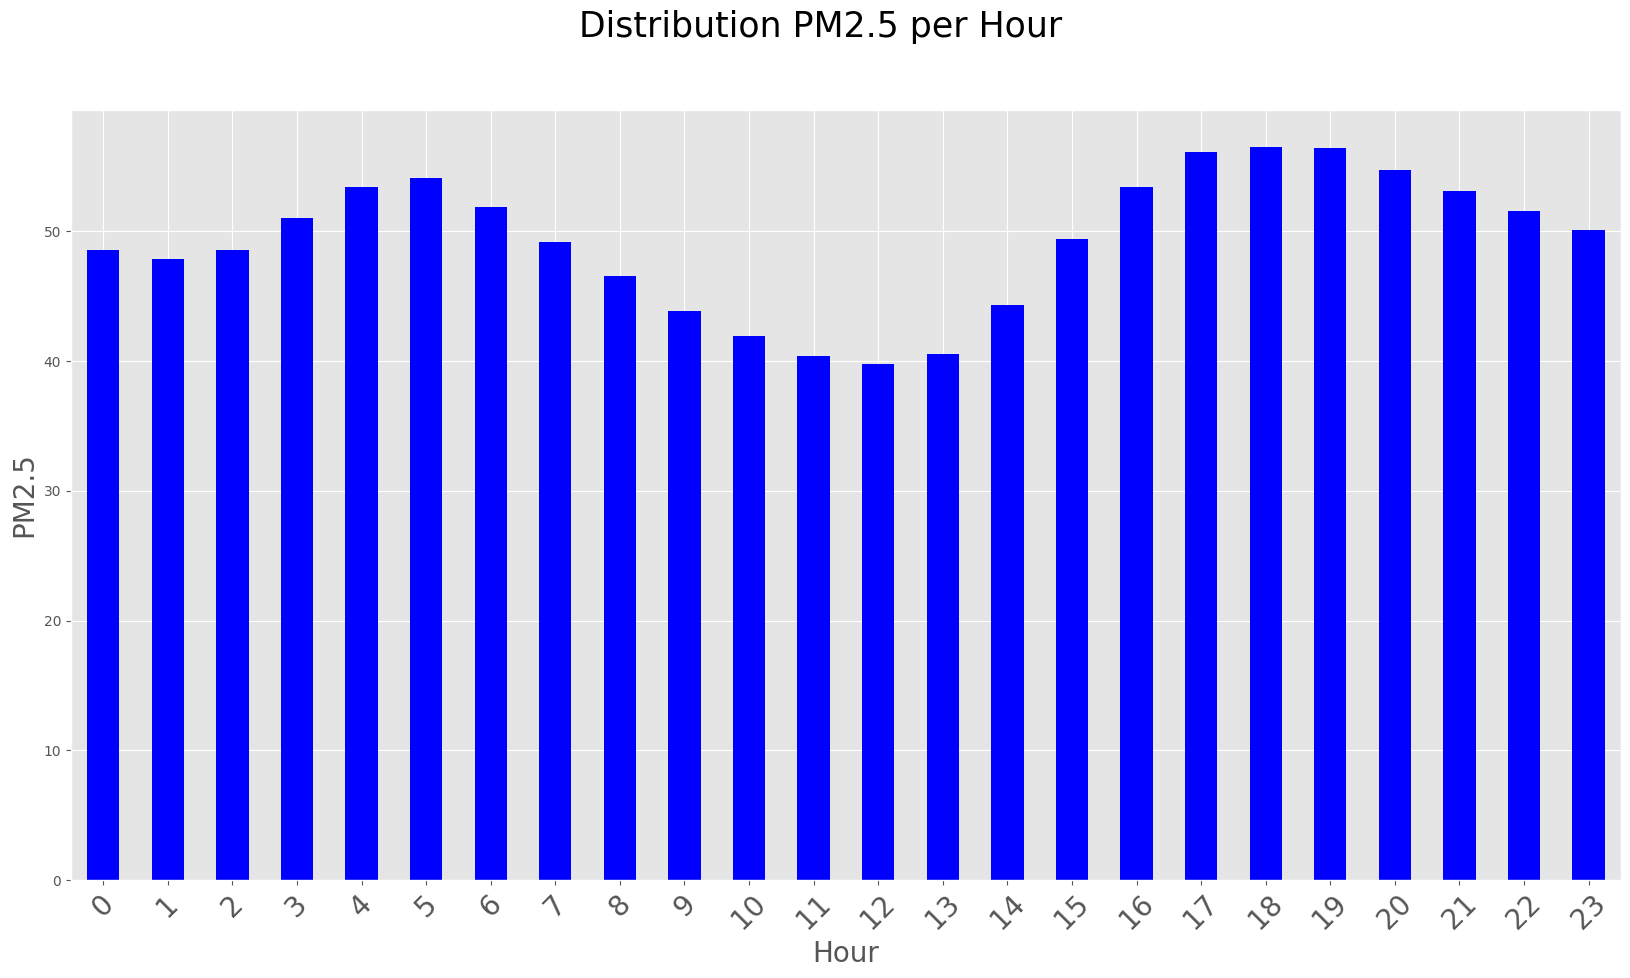

In [40]:
# Target variable distribution per hour
barplot(df1, var='Hour')

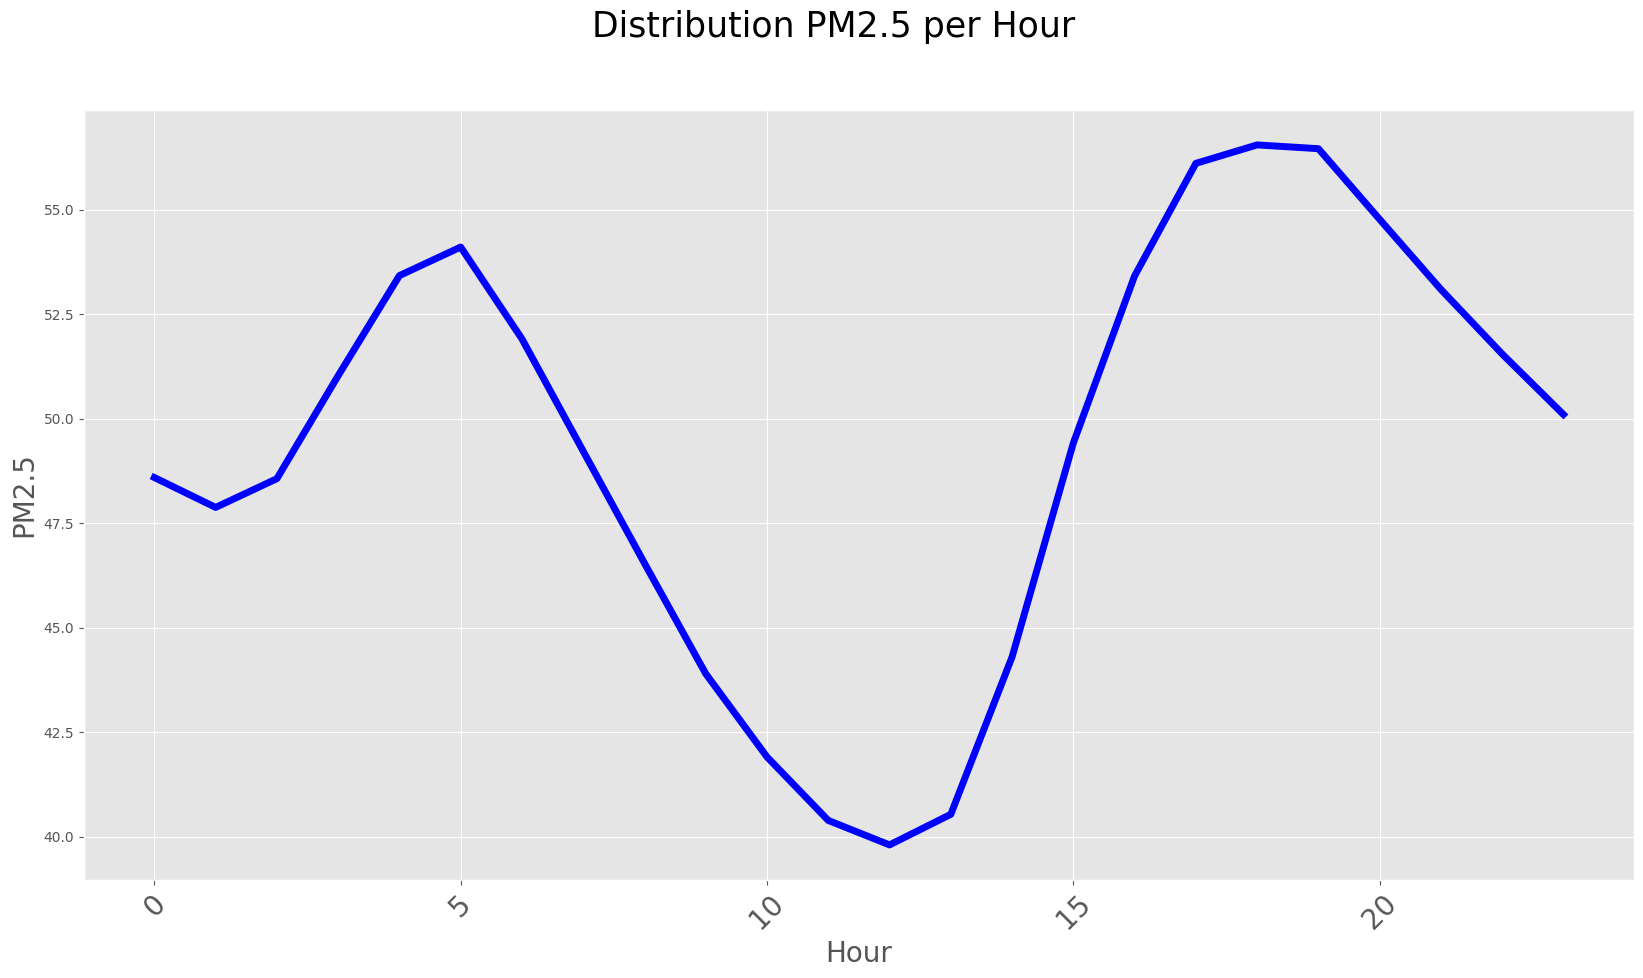

In [41]:
lineplot(df1,'Hour')

In [42]:
df1.groupby(df1['Hour'])['PM2.5'].mean()

Hour
0     48.590989
1     47.876001
2     48.563274
3     51.026848
4     53.420826
5     54.103601
6     51.906999
7     49.220218
8     46.540518
9     43.898124
10    41.906830
11    40.388280
12    39.802929
13    40.534937
14    44.298564
15    49.416037
16    53.412522
17    56.105450
18    56.547082
19    56.456744
20    54.766382
21    53.090369
22    51.545494
23    50.098299
Name: PM2.5, dtype: float64

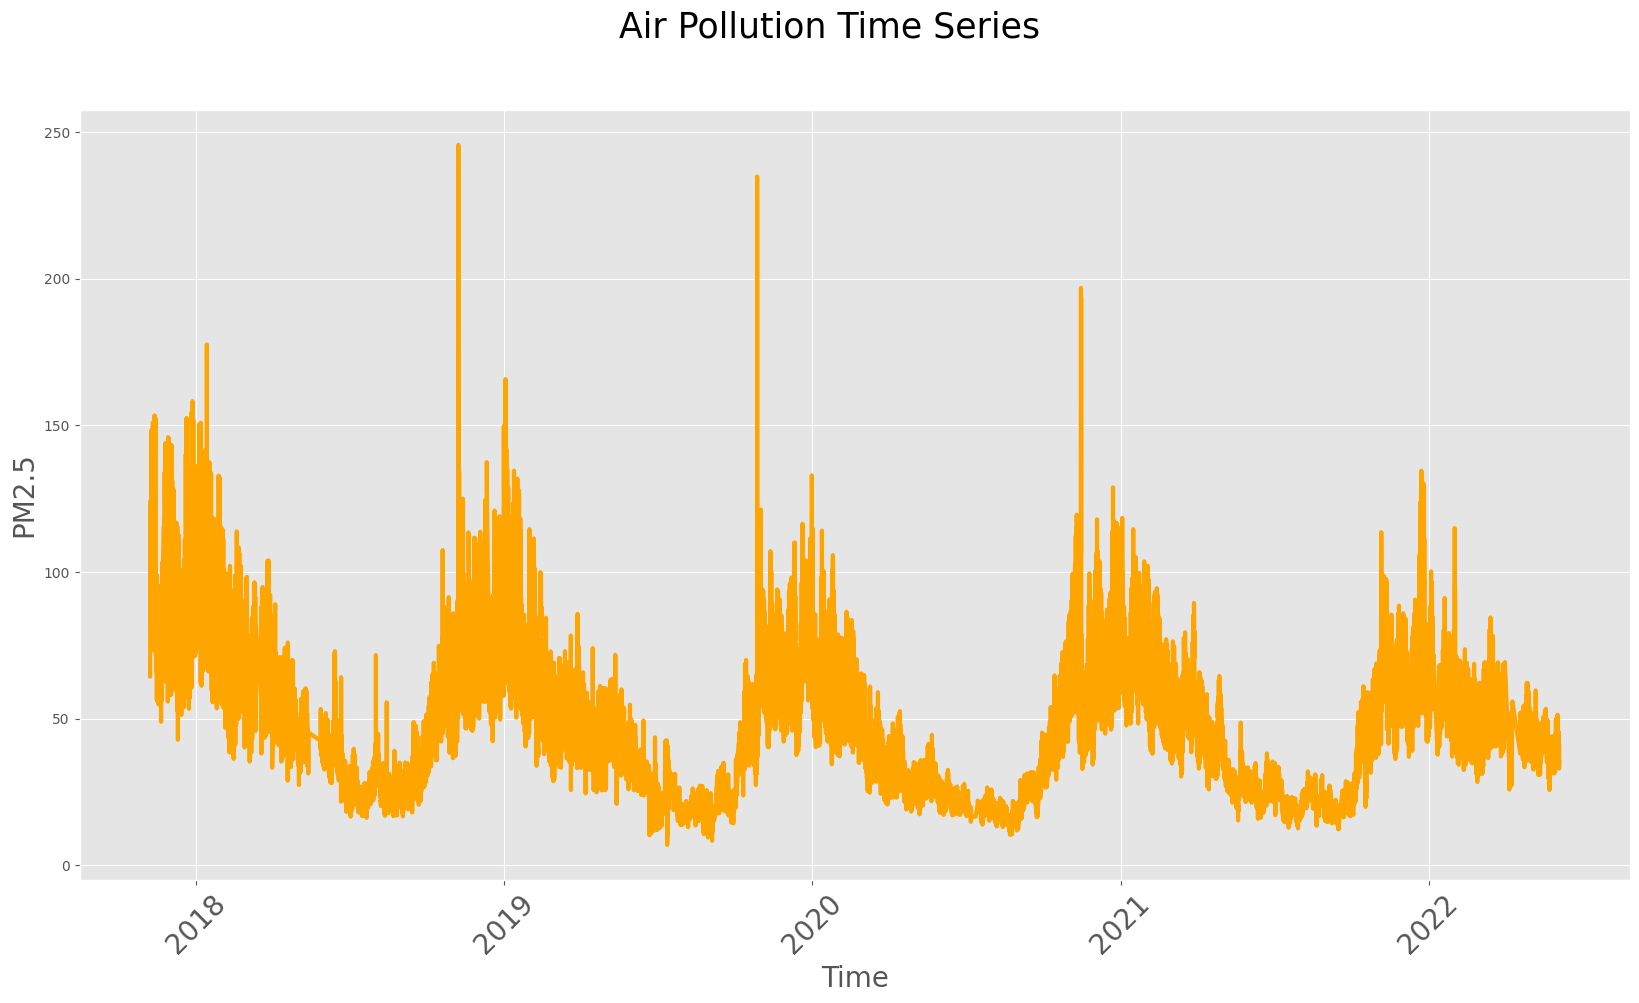

In [43]:
# Look at the whole Air Pollution time series
tsplot(df1, var='PM2.5', period='all')


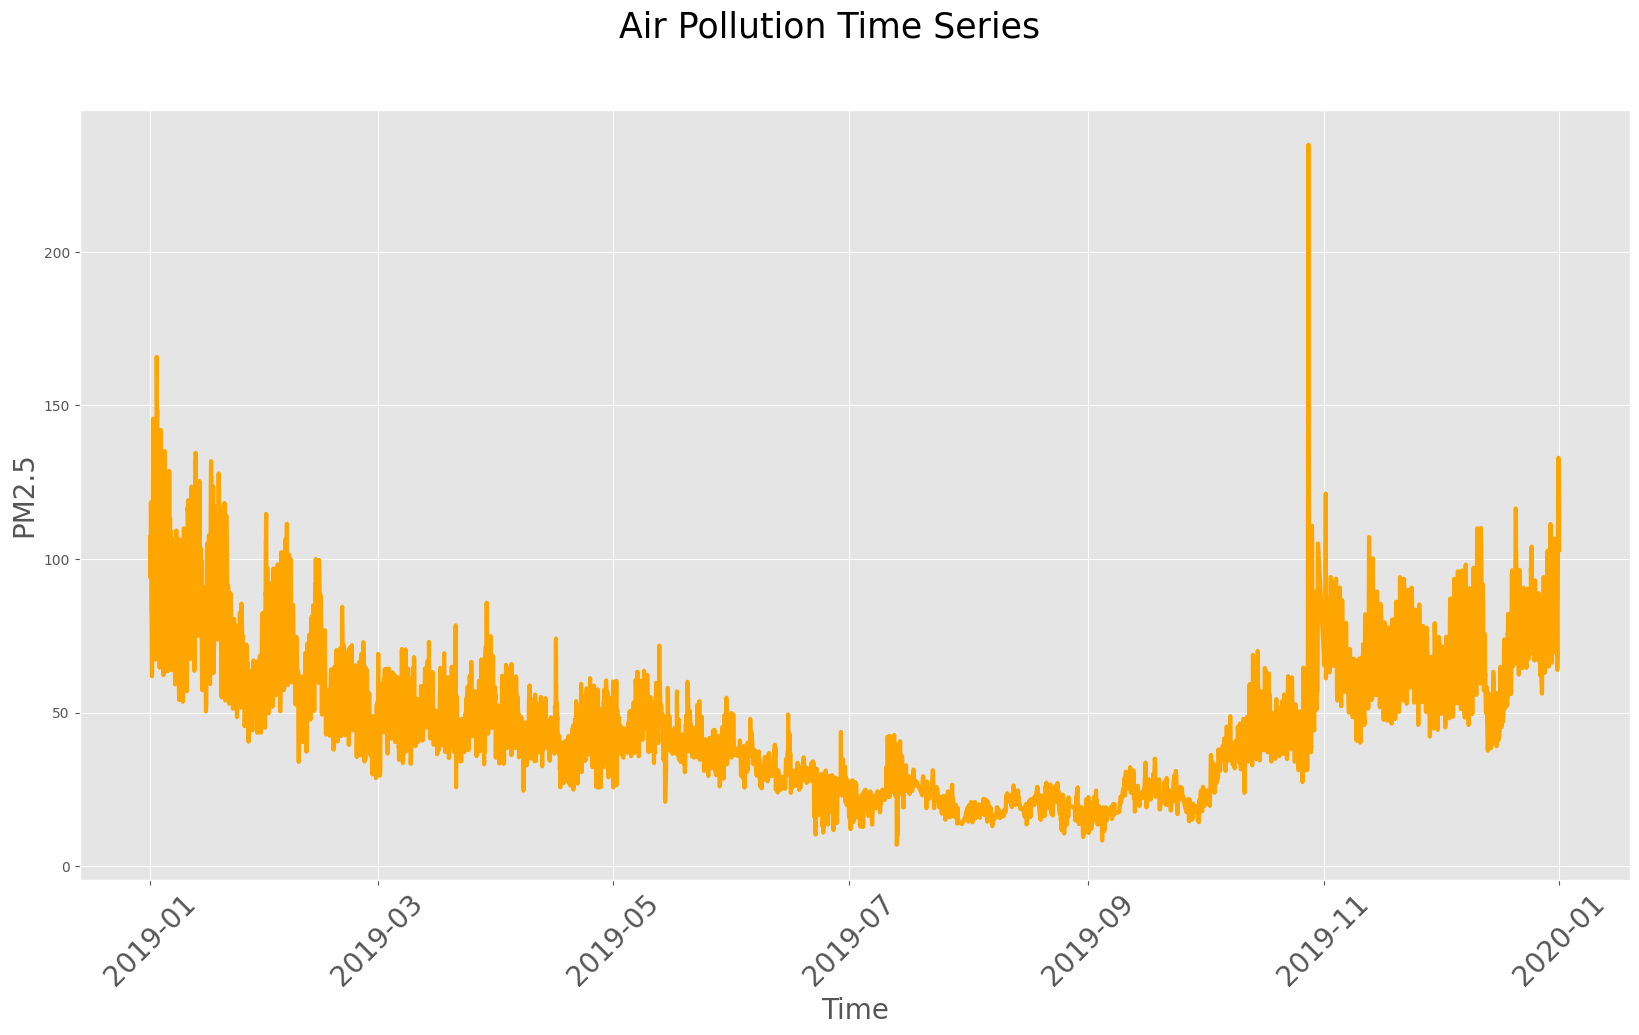

In [44]:
# Look at the single Air Pollution year
tsplot(df1,var='PM2.5', period='2019')


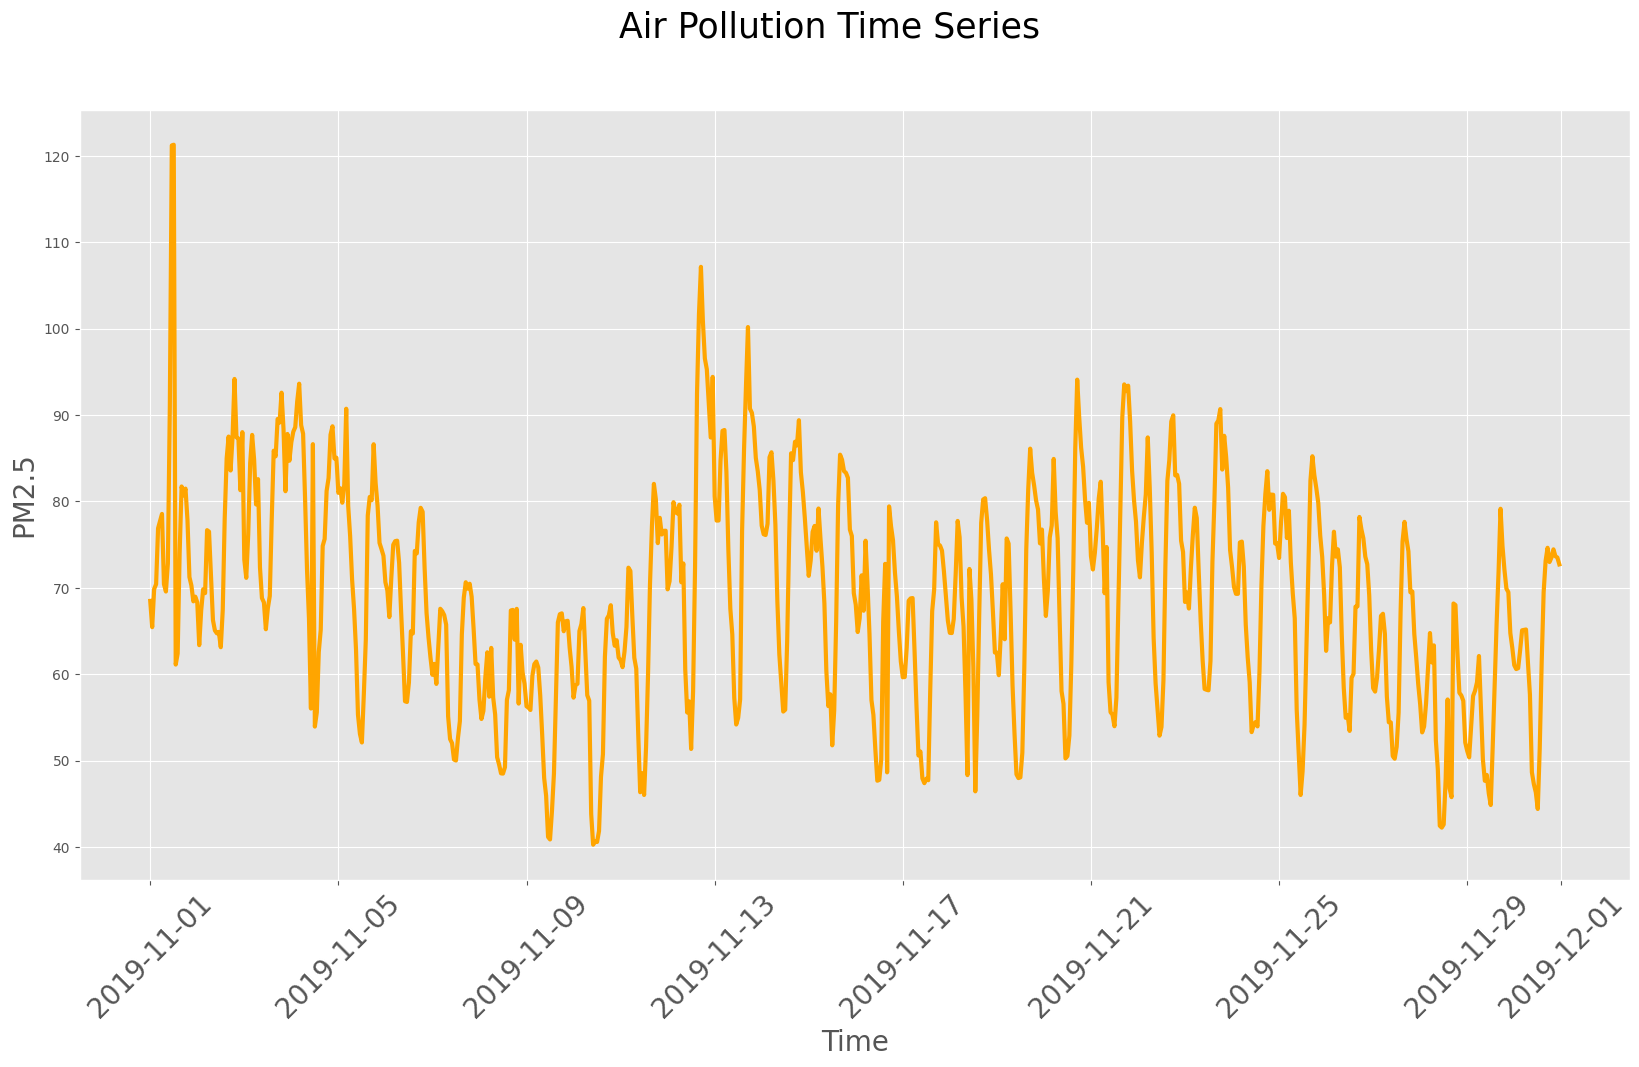

In [45]:
# Look at the single Air Pollution year-month
tsplot(df1,var='PM2.5', period='2019-11')


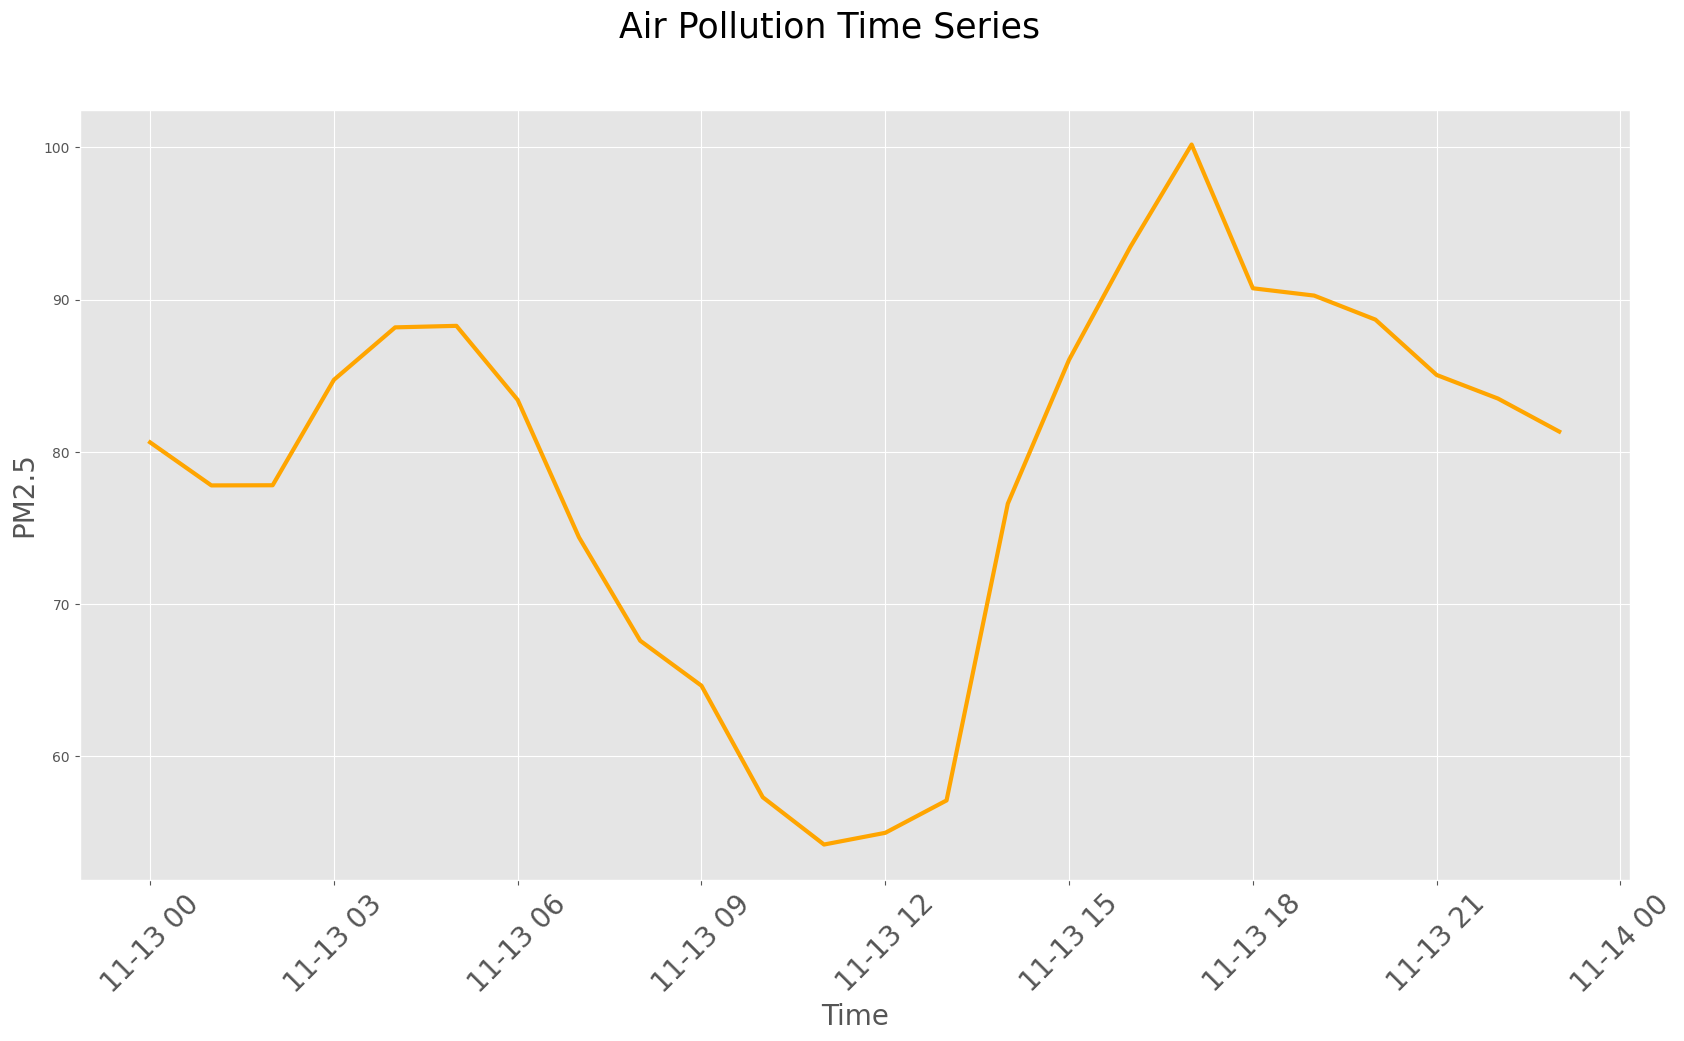

In [46]:
# Look at the single Air Pollution year-month-day
tsplot(df1,var='PM2.5', period='2019-11-13')


### Decomposition

In the decomposition of the time series, there is no evidence of seasonality patterns, trend has the same high width cyclic shape of the series both in the additive and multiplicative decomposition and doesn't show a specific up or down pattern. 

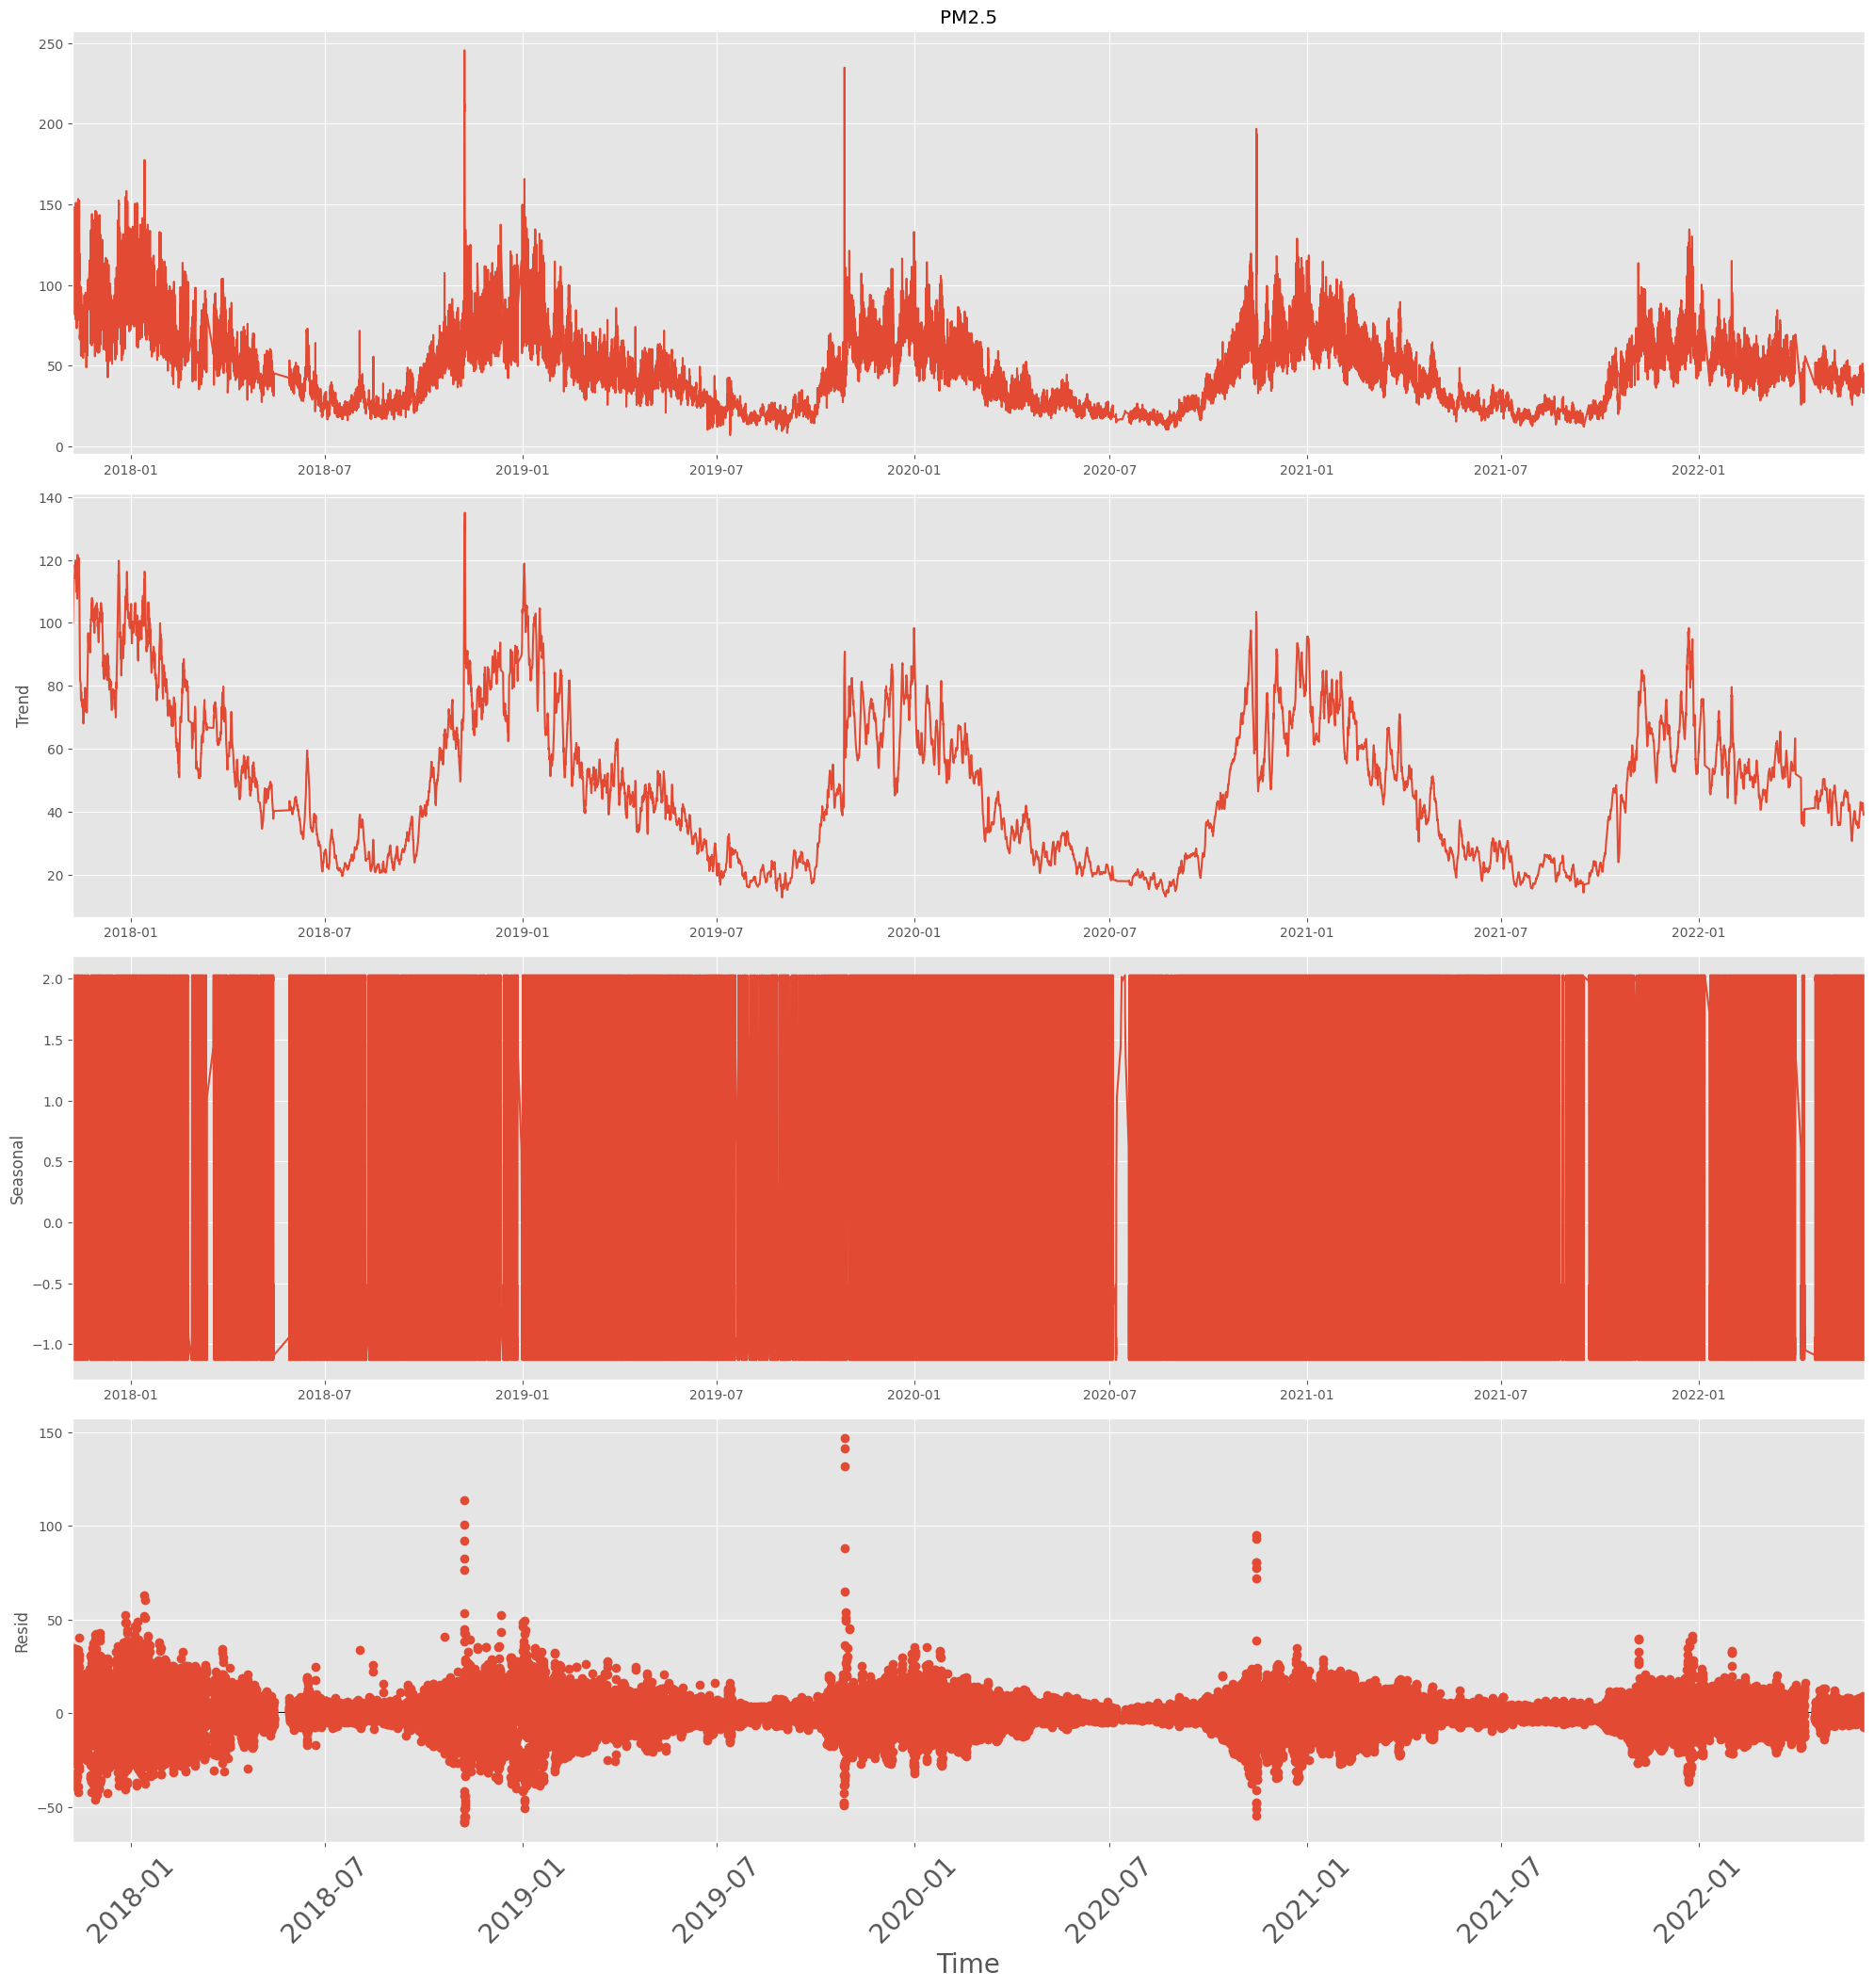

In [47]:
# Additive Decomposition
add_res = seasonal_decompose(x=df1['PM2.5'], model="additive", period=24)
plt.rcParams['figure.figsize']=(20,20)
add_res.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

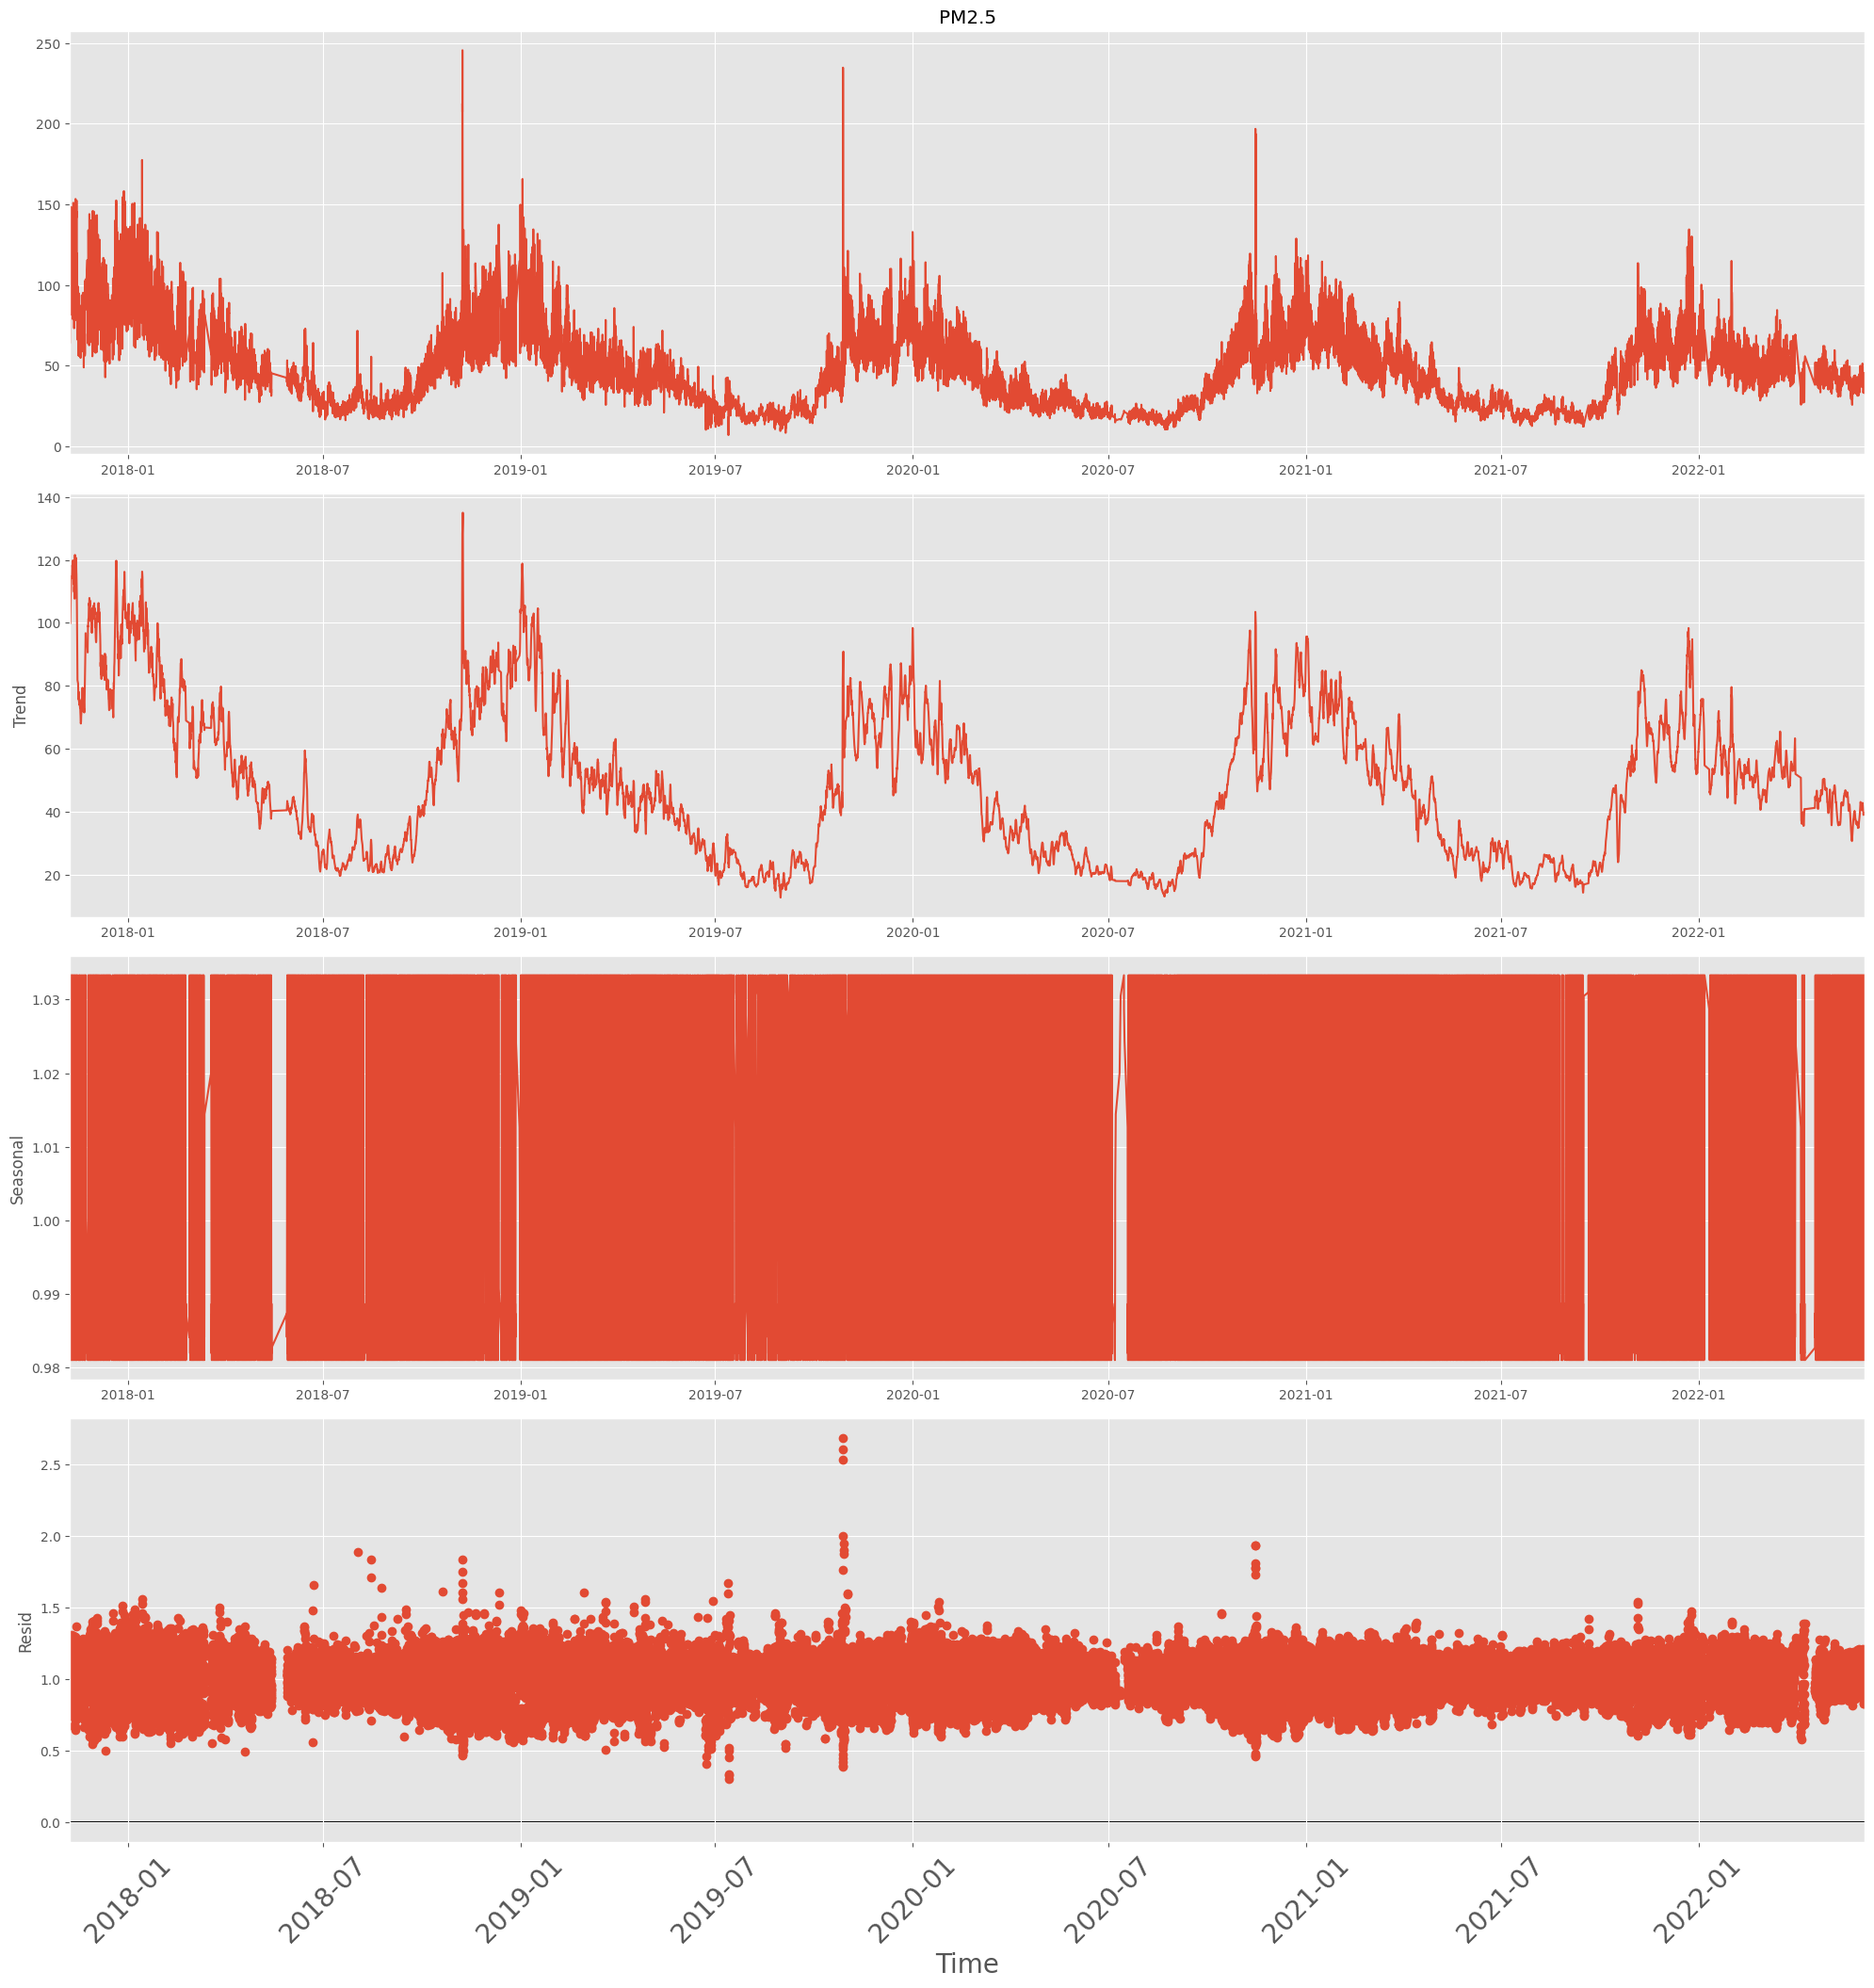

In [48]:
# Multiplicative Decomposition
mul_res = seasonal_decompose(x=df1['PM2.5'], model="multiplicative", period=24)
plt.rcParams['figure.figsize']=(20,20)
mul_res.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()



### Rolling window statistics

Last analysis has been done looking at the stationarity of the series. From the rolling window mean of observations, increasing window sizes have smoothed the shape over the time. This allows the model to make use of behaviours seen at different time scales.

In [49]:
# Create window features for rolling window
transformer = WindowFeatures(
    variables=["PM2.5"],
    functions=["mean", "std"],
    window=[24, 24 * 7, 24*30, 24 * 365], # Day, week, month, year.
    freq="1H",
)

df2 = transformer.fit_transform(df1)
df2

Year  Month  Day  Hour   PM2.5  PM2.5_window_24_mean  \
Timestamp                                                                   
2017-11-07 12:00:00  2017     11    7    12   64.51                   NaN   
2017-11-07 13:00:00  2017     11    7    13   69.95                   NaN   
2017-11-07 14:00:00  2017     11    7    14   92.79                   NaN   
2017-11-07 15:00:00  2017     11    7    15  109.66                   NaN   
2017-11-07 16:00:00  2017     11    7    16  116.50                   NaN   
...                   ...    ...  ...   ...     ...                   ...   
2022-06-04 11:00:00  2022      6    4    11   35.89             39.450000   
2022-06-04 12:00:00  2022      6    4    12   33.83             39.537500   
2022-06-04 13:00:00  2022      6    4    13   33.05             39.537083   
2022-06-04 14:00:00  2022      6    4    14   35.29             39.485417   
2022-06-04 15:00:00  2022      6    4    15   40.67             39.483750   

                     PM2.5_window_24_std  PM2.5_window_168_mean  \
Timestamp                                                         
2017-11-07 12:00:00                  NaN                    NaN   
2017-11-07 13:00:00                  NaN                    NaN   
2017-11-07 14:00:00                  NaN                    NaN   
2017-11-07 15:00:00                  NaN                    NaN   
2017-11-07 16:00:00                  NaN                    NaN   
...                                  ...                    ...   
2022-06-04 11:00:00             3.943142              39.317500   
2022-06-04 12:00:00             3.833869              39.318333   
2022-06-04 13:00:00             3.834515              39.304226   
2022-06-04 14:00:00             3.915782              39.286786   
2022-06-04 15:00:00             3.917636              39.272976   

                     PM2.5_window_168_std  PM2.5_window_720_mean  \
Timestamp                                                          
2017-11-07 12:00:00                   NaN                    NaN   
2017-11-07 13:00:00                   NaN                    NaN   
2017-11-07 14:00:00                   NaN                    NaN   
2017-11-07 15:00:00                   NaN                    NaN   
2017-11-07 16:00:00                   NaN                    NaN   
...                                   ...                    ...   
2022-06-04 11:00:00              4.344850              40.533514   
2022-06-04 12:00:00              4.344175              40.530153   
2022-06-04 13:00:00              4.358188              40.523694   
2022-06-04 14:00:00              4.377391              40.516236   
2022-06-04 15:00:00              4.386363              40.512042   

                     PM2.5_window_720_std  PM2.5_window_8760_mean  \
Timestamp                                                           
2017-11-07 12:00:00                   NaN                     NaN   
2017-11-07 13:00:00                   NaN                     NaN   
2017-11-07 14:00:00                   NaN                     NaN   
2017-11-07 15:00:00                   NaN                     NaN   
2017-11-07 16:00:00                   NaN                     NaN   
...                                   ...                     ...   
2022-06-04 11:00:00              5.306699               42.016067   
2022-06-04 12:00:00              5.308875               42.015701   
2022-06-04 13:00:00              5.314198               42.015573   
2022-06-04 14:00:00              5.320919               42.015403   
2022-06-04 15:00:00              5.323850               42.015731   

                     PM2.5_window_8760_std  
Timestamp                                   
2017-11-07 12:00:00                    NaN  
2017-11-07 13:00:00                    NaN  
2017-11-07 14:00:00                    NaN  
2017-11-07 15:00:00                    NaN  
2017-11-07 16:00:00                    NaN  
...                                    ...  
2022

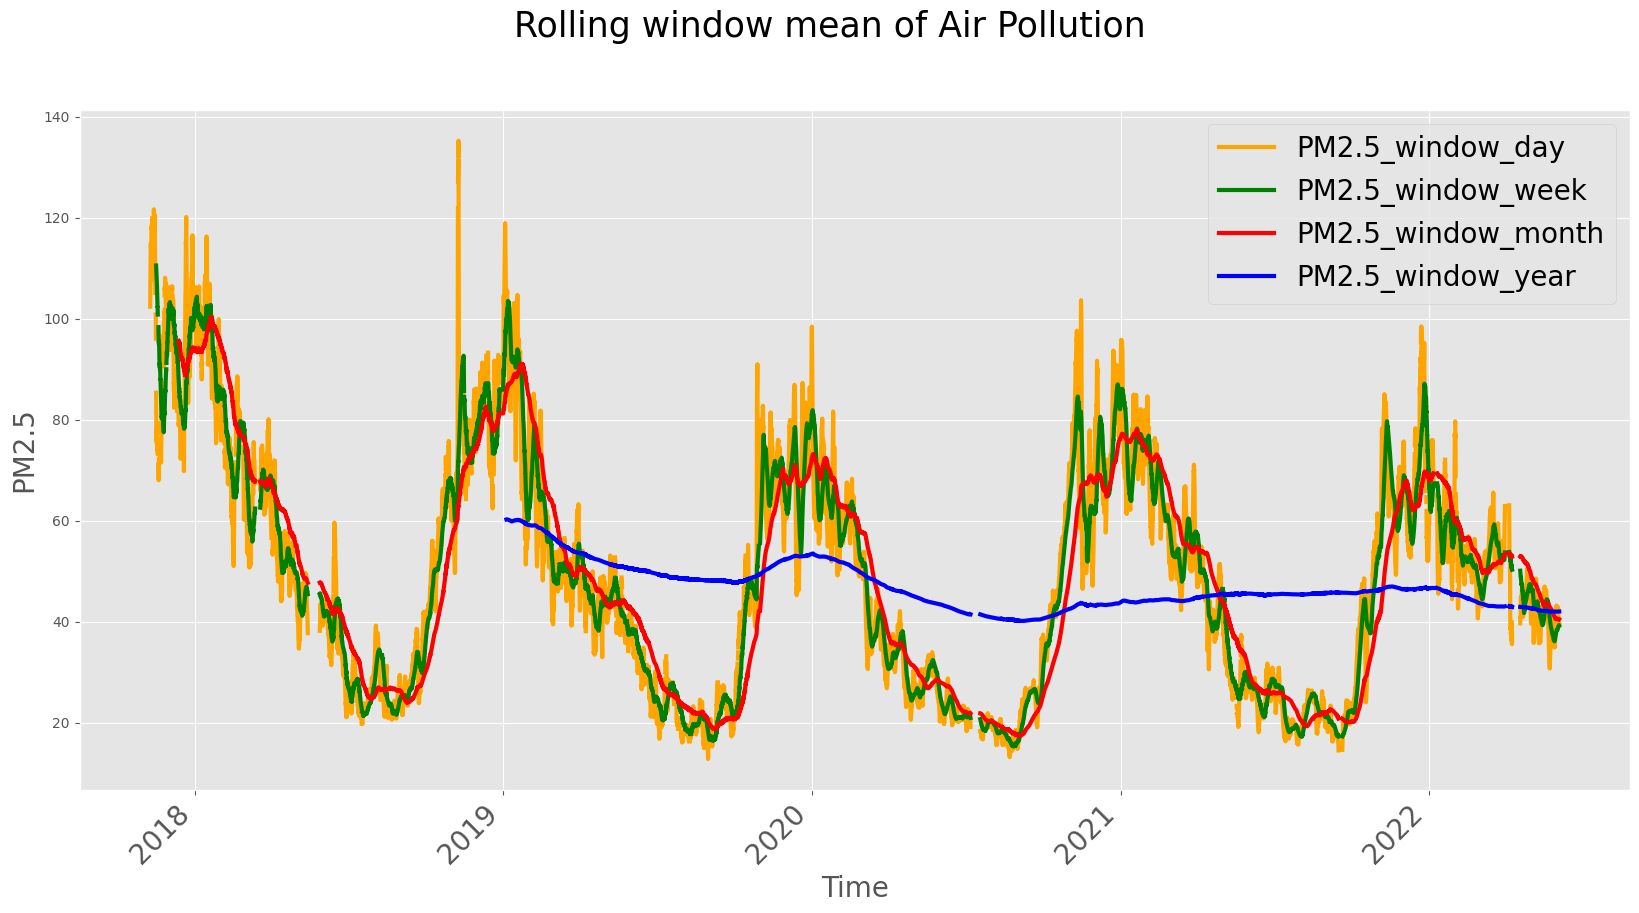

In [50]:
# Plot time series with mean rolling window for day, week, month and year 
colors = ['orange', 'green', 'red', 'blue']
df2.filter(
    regex="PM2.5_.*?_mean", # `.*?` means any number of any characters.
    axis=1  # Filter by column names.
).plot(color=colors, linewidth=3,figsize=(20,10))
my_labels=['PM2.5_window_day', 'PM2.5_window_week','PM2.5_window_month','PM2.5_window_year']
plt.suptitle("Rolling window mean of Air Pollution",fontsize=25)
plt.xlabel('Time', fontsize=20)
plt.ylabel('PM2.5', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.legend(my_labels,fontsize=20)
plt.show()

### Stationarity

Checking consistent summary statistics at the partitioned series, as mean and variance over time, suggest to apply the log transformation at the target values, also confirmed looking at the histogram of the air pollution distribution. At the end, the Augmented Dickey-Fuller test, that uses an autoregressive model, reject the null hypothesis that means the time series is stationary, it doesn't have time dependent structure.

In [51]:
#  statistics of partitioned time series 
X = df1['PM2.5'].values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=55.226992, mean2=43.389866
variance1=712.521530, variance2=453.773863


In [52]:
#  statistics of log partitioned time series
X = df1['PM2.5'].values
X = np.log1p(X)
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3.912645, mean2=3.677782
variance1=0.246803, variance2=0.235777


In [53]:
# Augmented Dickey-Fuller test
X = df1['PM2.5'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.168240
p-value: 0.000010
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Select a sub-set


In [54]:
# remove inconsistent data
df3 = df1.query('Year>=2018 and Year <=2021')

### Remove outliers

Outliers in time series are anomaly observations on patterns and trends collected in the values of the time series. Detecting outliers in time series is helpful because outliers can influence the forecast model that is used to predict future values. OutlIers have been detected and removed by the Hampel identifier, replacing with the median each sample that differ from the median by more than three times the median absolute deviation.

In [55]:
ts = df3['PM2.5'].copy() 

In [56]:
# Outliers imputation with rolling median
ts_out = hampel(ts, window_size=24, imputation=True)


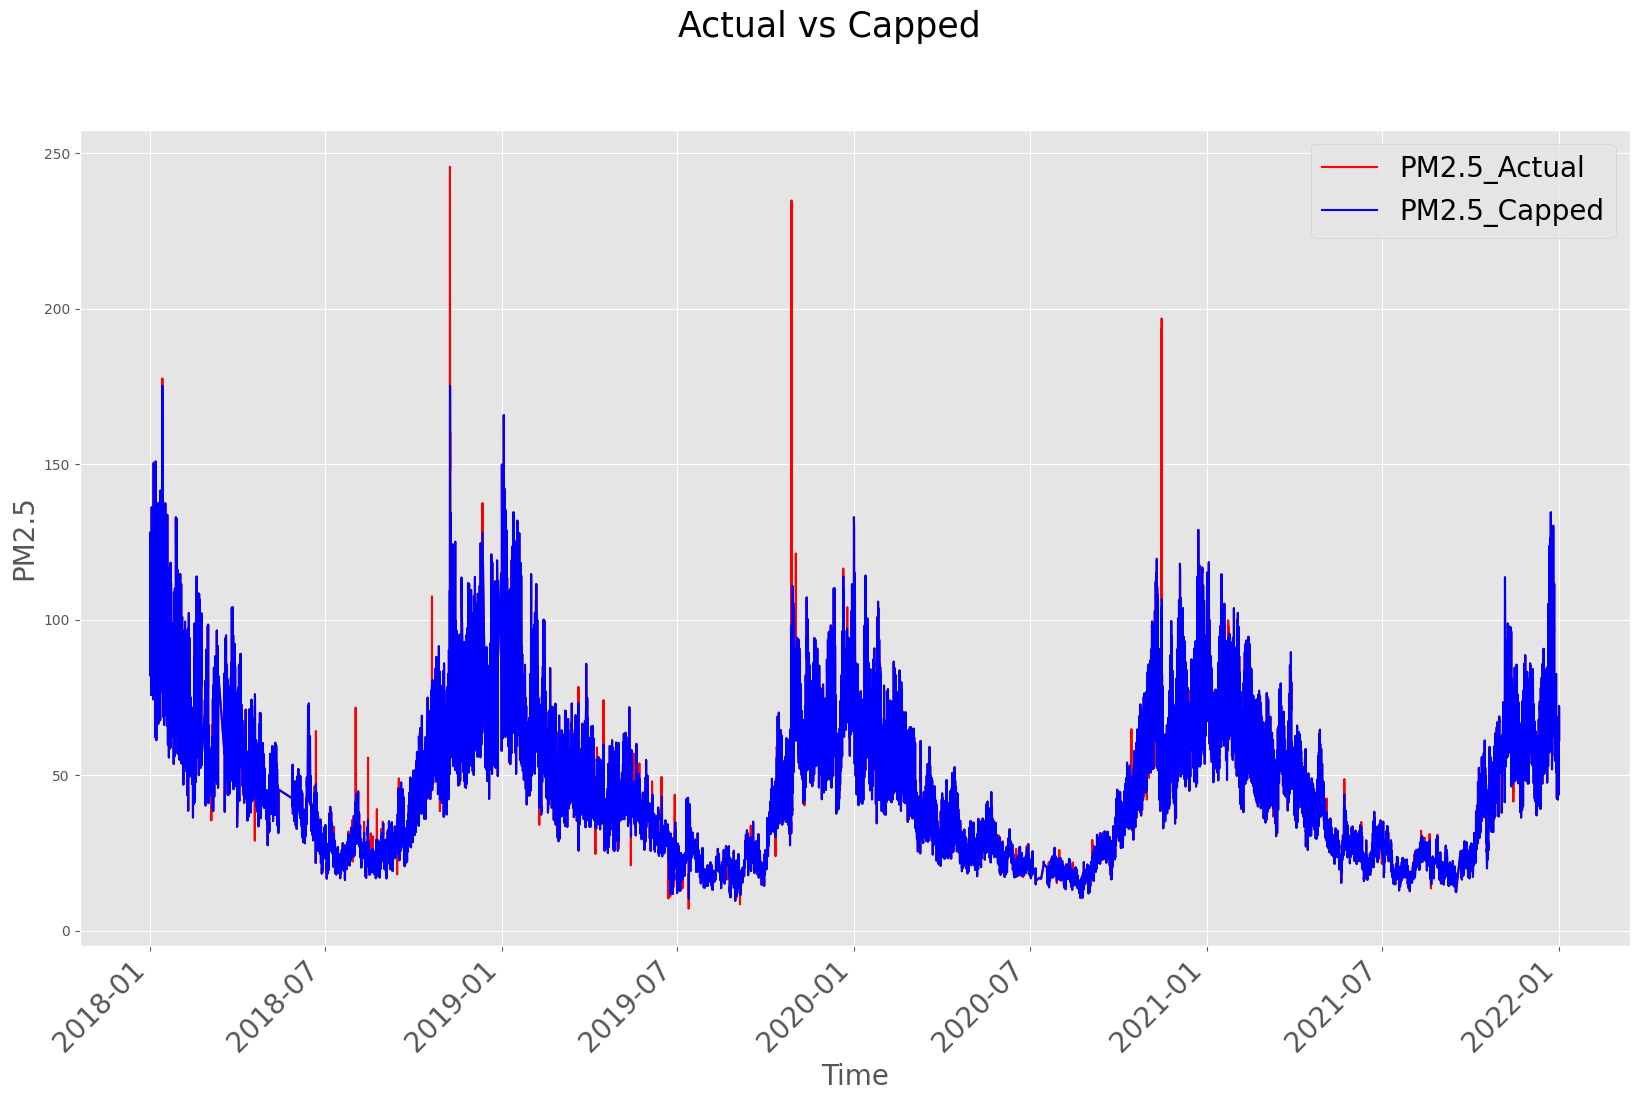

In [57]:
# Actual distribution vs Capped distribution plot
plt.rcParams['figure.figsize']=(20,12)
ts.plot(style="r-")
ts_out.plot(style="b-")
my_labels=['PM2.5_Actual', 'PM2.5_Capped']
plt.suptitle("Actual vs Capped",fontsize=25)
plt.xlabel('Time', fontsize=20)
plt.ylabel('PM2.5', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.legend(my_labels,fontsize=20)
plt.show()

### Feature Engineering with Lag features

The approach pursued has been to transform the time series forecasting into a supervised learning problem, and for this purpose there have been generated lag features with shifted values following the sliding window method, so lag features generated are the PM2.5 values shifted by 1 hour, 2 hours, 3 hours, 1 day, a week and the rolling mean, rolling max, rolling min of one day and a week.

In [58]:
# Lag features
df_lag = pd.concat(
    [
        ts_out,
        ts_out.shift(1).rename("lagged_1h"),
        ts_out.shift(2).rename("lagged_2h"),
        ts_out.shift(3).rename("lagged_3h"),
        ts_out.shift(24).rename("lagged_1d"),
        ts_out.shift(7 * 24).rename("lagged_7d"),
        ts_out.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        ts_out.shift(1).rolling(24).max().rename("lagged_max_24h"),
        ts_out.shift(1).rolling(24).min().rename("lagged_min_24h"),
        ts_out.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        ts_out.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        ts_out.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
)


In [59]:
df_lag.head()

PM2.5  lagged_1h  lagged_2h  lagged_3h  lagged_1d  \
Timestamp                                                                 
2018-01-01 00:00:00   90.19        NaN        NaN        NaN        NaN   
2018-01-01 01:00:00   86.98      90.19        NaN        NaN        NaN   
2018-01-01 02:00:00   86.06      86.98      90.19        NaN        NaN   
2018-01-01 03:00:00   94.04      86.06      86.98      90.19        NaN   
2018-01-01 04:00:00  108.78      94.04      86.06      86.98        NaN   

                     lagged_7d  lagged_mean_24h  lagged_max_24h  \
Timestamp                                                         
2018-01-01 00:00:00        NaN              NaN             NaN   
2018-01-01 01:00:00        NaN              NaN             NaN   
2018-01-01 02:00:00        NaN              NaN             NaN   
2018-01-01 03:00:00        NaN              NaN             NaN   
2018-01-01 04:00:00        NaN              NaN             NaN   

                     lagged_min_24h  lagged_mean_7d  lagged_max_7d  \
Timestamp                                                            
2018-01-01 00:00:00             NaN             NaN            NaN   
2018-01-01 01:00:00             NaN             NaN            NaN   
2018-01-01 02:00:00             NaN             NaN            NaN   
2018-01-01 03:00:00             NaN             NaN            NaN   
2018-01-01 04:00:00             NaN             NaN            NaN   

                     lagged_min_7d  
Timestamp                           
2018-01-01 00:00:00            NaN  
2018-01-01 01:00:00            NaN  
2018-01-01 02:00:00            NaN  
2018-01-01 03:00:00            NaN  
2018-01-01 04:00:00            NaN

In [60]:
df_lag.tail()

PM2.5  lagged_1h  lagged_2h  lagged_3h  lagged_1d  \
Timestamp                                                                
2021-12-31 19:00:00  72.25      65.38      64.83      56.73      55.61   
2021-12-31 20:00:00  71.56      72.25      65.38      64.83      62.60   
2021-12-31 21:00:00  70.27      71.56      72.25      65.38      62.13   
2021-12-31 22:00:00  66.78      70.27      71.56      72.25      52.56   
2021-12-31 23:00:00  61.29      66.78      70.27      71.56      49.77   

                     lagged_7d  lagged_mean_24h  lagged_max_24h  \
Timestamp                                                         
2021-12-31 19:00:00      51.86        54.007917           65.38   
2021-12-31 20:00:00      53.41        54.701250           72.25   
2021-12-31 21:00:00      57.40        55.074583           72.25   
2021-12-31 22:00:00      65.02        55.413750           72.25   
2021-12-31 23:00:00      74.35        56.006250           72.25   

                     lagged_min_24h  lagged_mean_7d  lagged_max_7d  \
Timestamp                                                            
2021-12-31 19:00:00           43.73       69.865417         130.21   
2021-12-31 20:00:00           43.73       69.986786         130.21   
2021-12-31 21:00:00           43.73       70.094821         130.21   
2021-12-31 22:00:00           43.73       70.171429         130.21   
2021-12-31 23:00:00           43.73       70.181905         130.21   

                     lagged_min_7d  
Timestamp                           
2021-12-31 19:00:00          42.13  
2021-12-31 20:00:00          42.13  
2021-12-31 21:00:00          42.13  
2021-12-31 22:00:00          42.13  
2021-12-31 23:00:00          42.13

In [61]:
# Remove nan values
df_lag = df_lag.dropna()

### Split dataset

In [62]:
y = df_lag['PM2.5']
X = df_lag.drop(['PM2.5'], axis=1)
# Test set on 1 month
split_point = len(df_lag) - 24*30
X_train, X_test = X[0:split_point], X[split_point:]
y_train, y_test = y[0:split_point], y[split_point:]

In [63]:
# Split for time series cross validation
ts_cv = TimeSeriesSplit(n_splits=3, test_size=24*30)
# splits
splits = list(ts_cv.split(X, y))

### Autoregressive model

The autoregressive model uses observations from previous time steps, called lag variables, as input variables in the regression equation to predict the value at the next time step. This process is derived from linear regression, because the model uses data from the same input variable at previous time steps, so it's an autoregression. It's used as a benchmark model for this research, as the time series is stationary.

In [64]:
# Features to introduce in the model
exog_train = X_train[['lagged_1d','lagged_7d','lagged_mean_24h','lagged_max_24h','lagged_min_24h','lagged_mean_7d','lagged_max_7d','lagged_min_7d']]
exog_test = X_test[['lagged_1d','lagged_7d','lagged_mean_24h','lagged_max_24h','lagged_min_24h','lagged_mean_7d','lagged_max_7d','lagged_min_7d']]


In [65]:
# train autoregression
AR = AutoReg(np.log1p(y_train), exog=exog_train, lags=3)
AR_model = AR.fit()
# make prediction
y_hat = AR_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog_oos=exog_test)

In [66]:
# Evaluation
print('Test evaluation')
rmse = np.sqrt(mean_squared_error(np.log1p(y_test.values), y_hat.values))
print(f"root_mean_squared_error: {rmse:.3f} ± {rmse.std():.3f}")
mae = mean_absolute_error(np.log1p(y_test.values), y_hat.values)
print(f"mean_absolute_error: {mae:.3f} ± {mae.std():.3f}")


Test evaluation
root_mean_squared_error: 0.195 ± 0.000
mean_absolute_error: 0.156 ± 0.000


In [67]:
# Build a dataframe with actual and predicted values
AR_test = np.expm1(y_hat)
AR_test_df = pd.DataFrame(AR_test, columns=['PM2.5_estimation'])
y_test_ = pd.DataFrame(y_test, columns=['PM2.5'])
df_AR_fin = pd.concat([y_test_['PM2.5'], AR_test_df.set_index(y_test_.index)], axis=1)

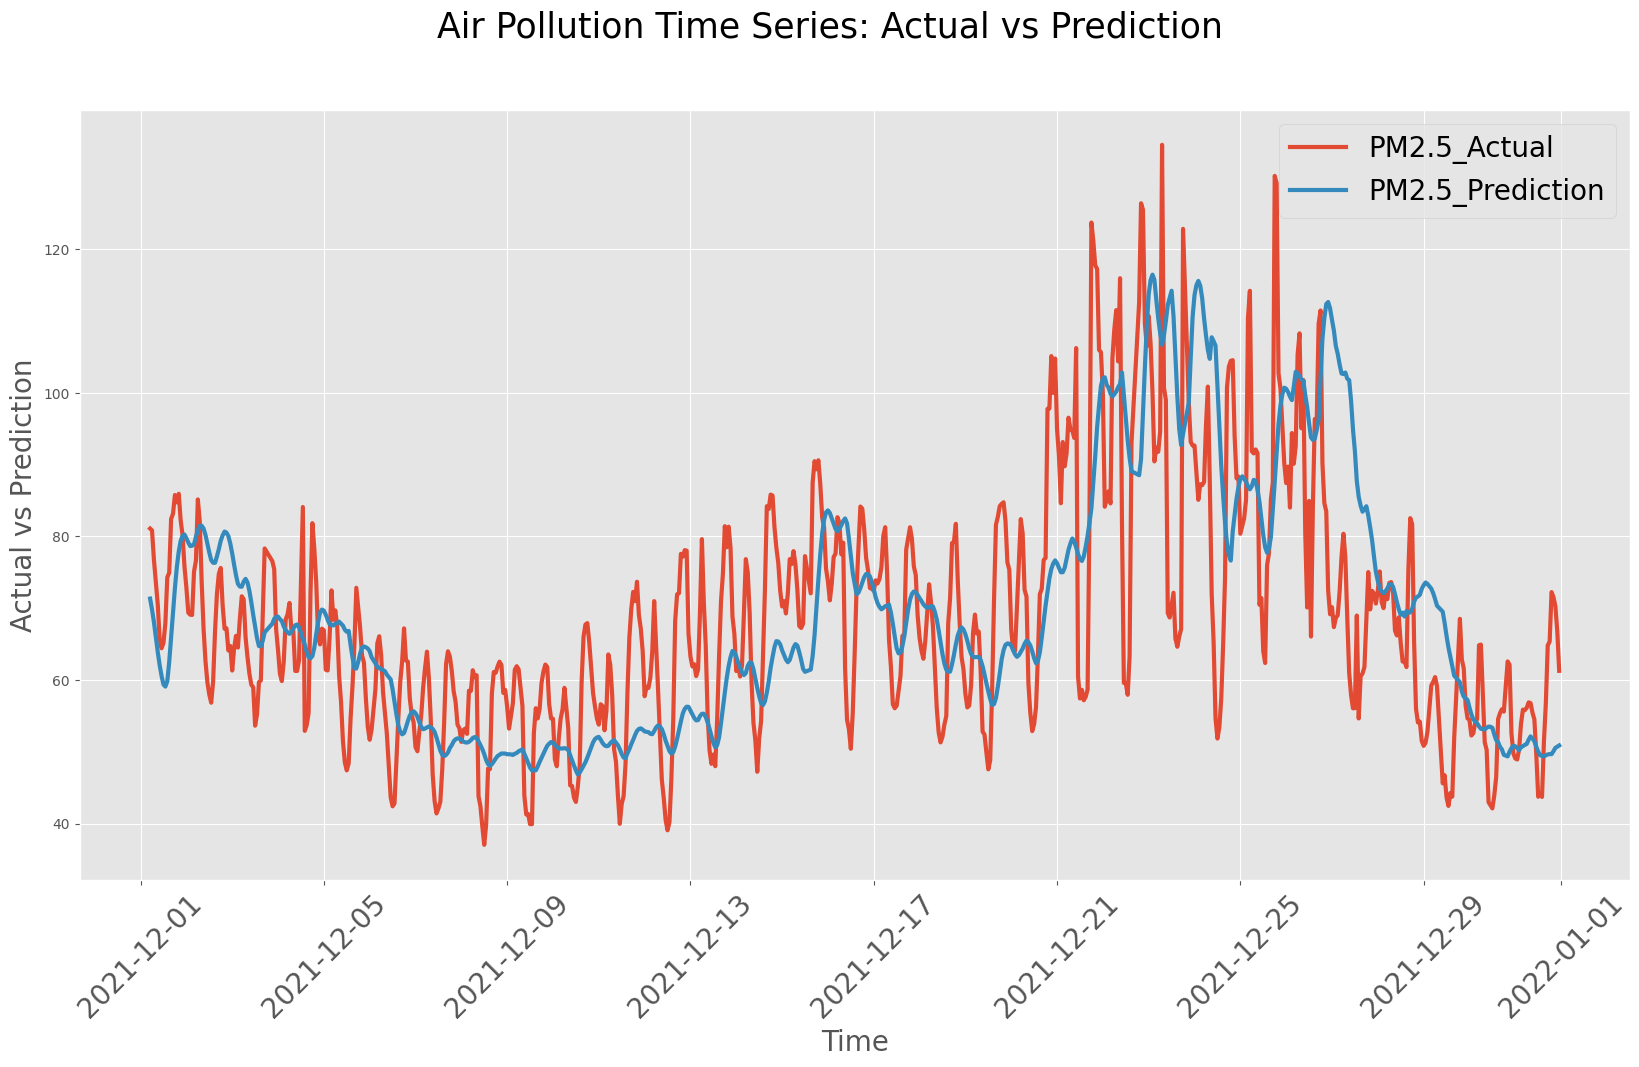

In [68]:
# Plot results on a time period
tsmultiplot(df_AR_fin,period='2021-12')
plt.show()

In [69]:
# Look at the model results
print(AR_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  PM2.5   No. Observations:                30973
Model:                   AutoReg-X(3)   Log Likelihood               31606.237
Method:               Conditional MLE   S.D. of innovations              0.087
Date:                Sun, 21 May 2023   AIC                         -63186.474
Time:                        01:46:07   BIC                         -63078.044
Sample:                             3   HQIC                        -63151.735
                                30973                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4985      0.009     57.708      0.000       0.482       0.515
PM2.5.L1            0.9556      0.006    166.029      0.000       0.944       0.967
PM2.5.L2            0.0338      

In [70]:
# Features Importance based on pvalues
print('AR Features Importance by pvalues')
AR_model.pvalues.sort_values()

AR Features Importance by pvalues


const               0.000000e+00
PM2.5.L1            0.000000e+00
PM2.5.L3           7.624033e-202
lagged_1d           2.855567e-46
lagged_mean_24h     6.860920e-13
lagged_min_24h      9.113870e-11
lagged_7d           1.210411e-09
PM2.5.L2            1.787070e-05
lagged_min_7d       1.629671e-04
lagged_mean_7d      3.486039e-01
lagged_max_7d       3.755678e-01
lagged_max_24h      5.090495e-01
dtype: float64

In [71]:
# Features Importance based on estimated coefficients
print('AR Features Importance by coefficients')
AR_model.params.sort_values(ascending=False)

AR Features Importance by coefficients


PM2.5.L1           0.955617
const              0.498500
PM2.5.L2           0.033804
lagged_mean_24h    0.001802
lagged_min_24h     0.001108
lagged_1d          0.000899
lagged_min_7d      0.000715
lagged_7d          0.000297
lagged_max_24h     0.000086
lagged_max_7d     -0.000066
lagged_mean_7d    -0.000183
PM2.5.L3          -0.173993
dtype: float64

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
Partial regression plot of AIR Pollution on features with AR model


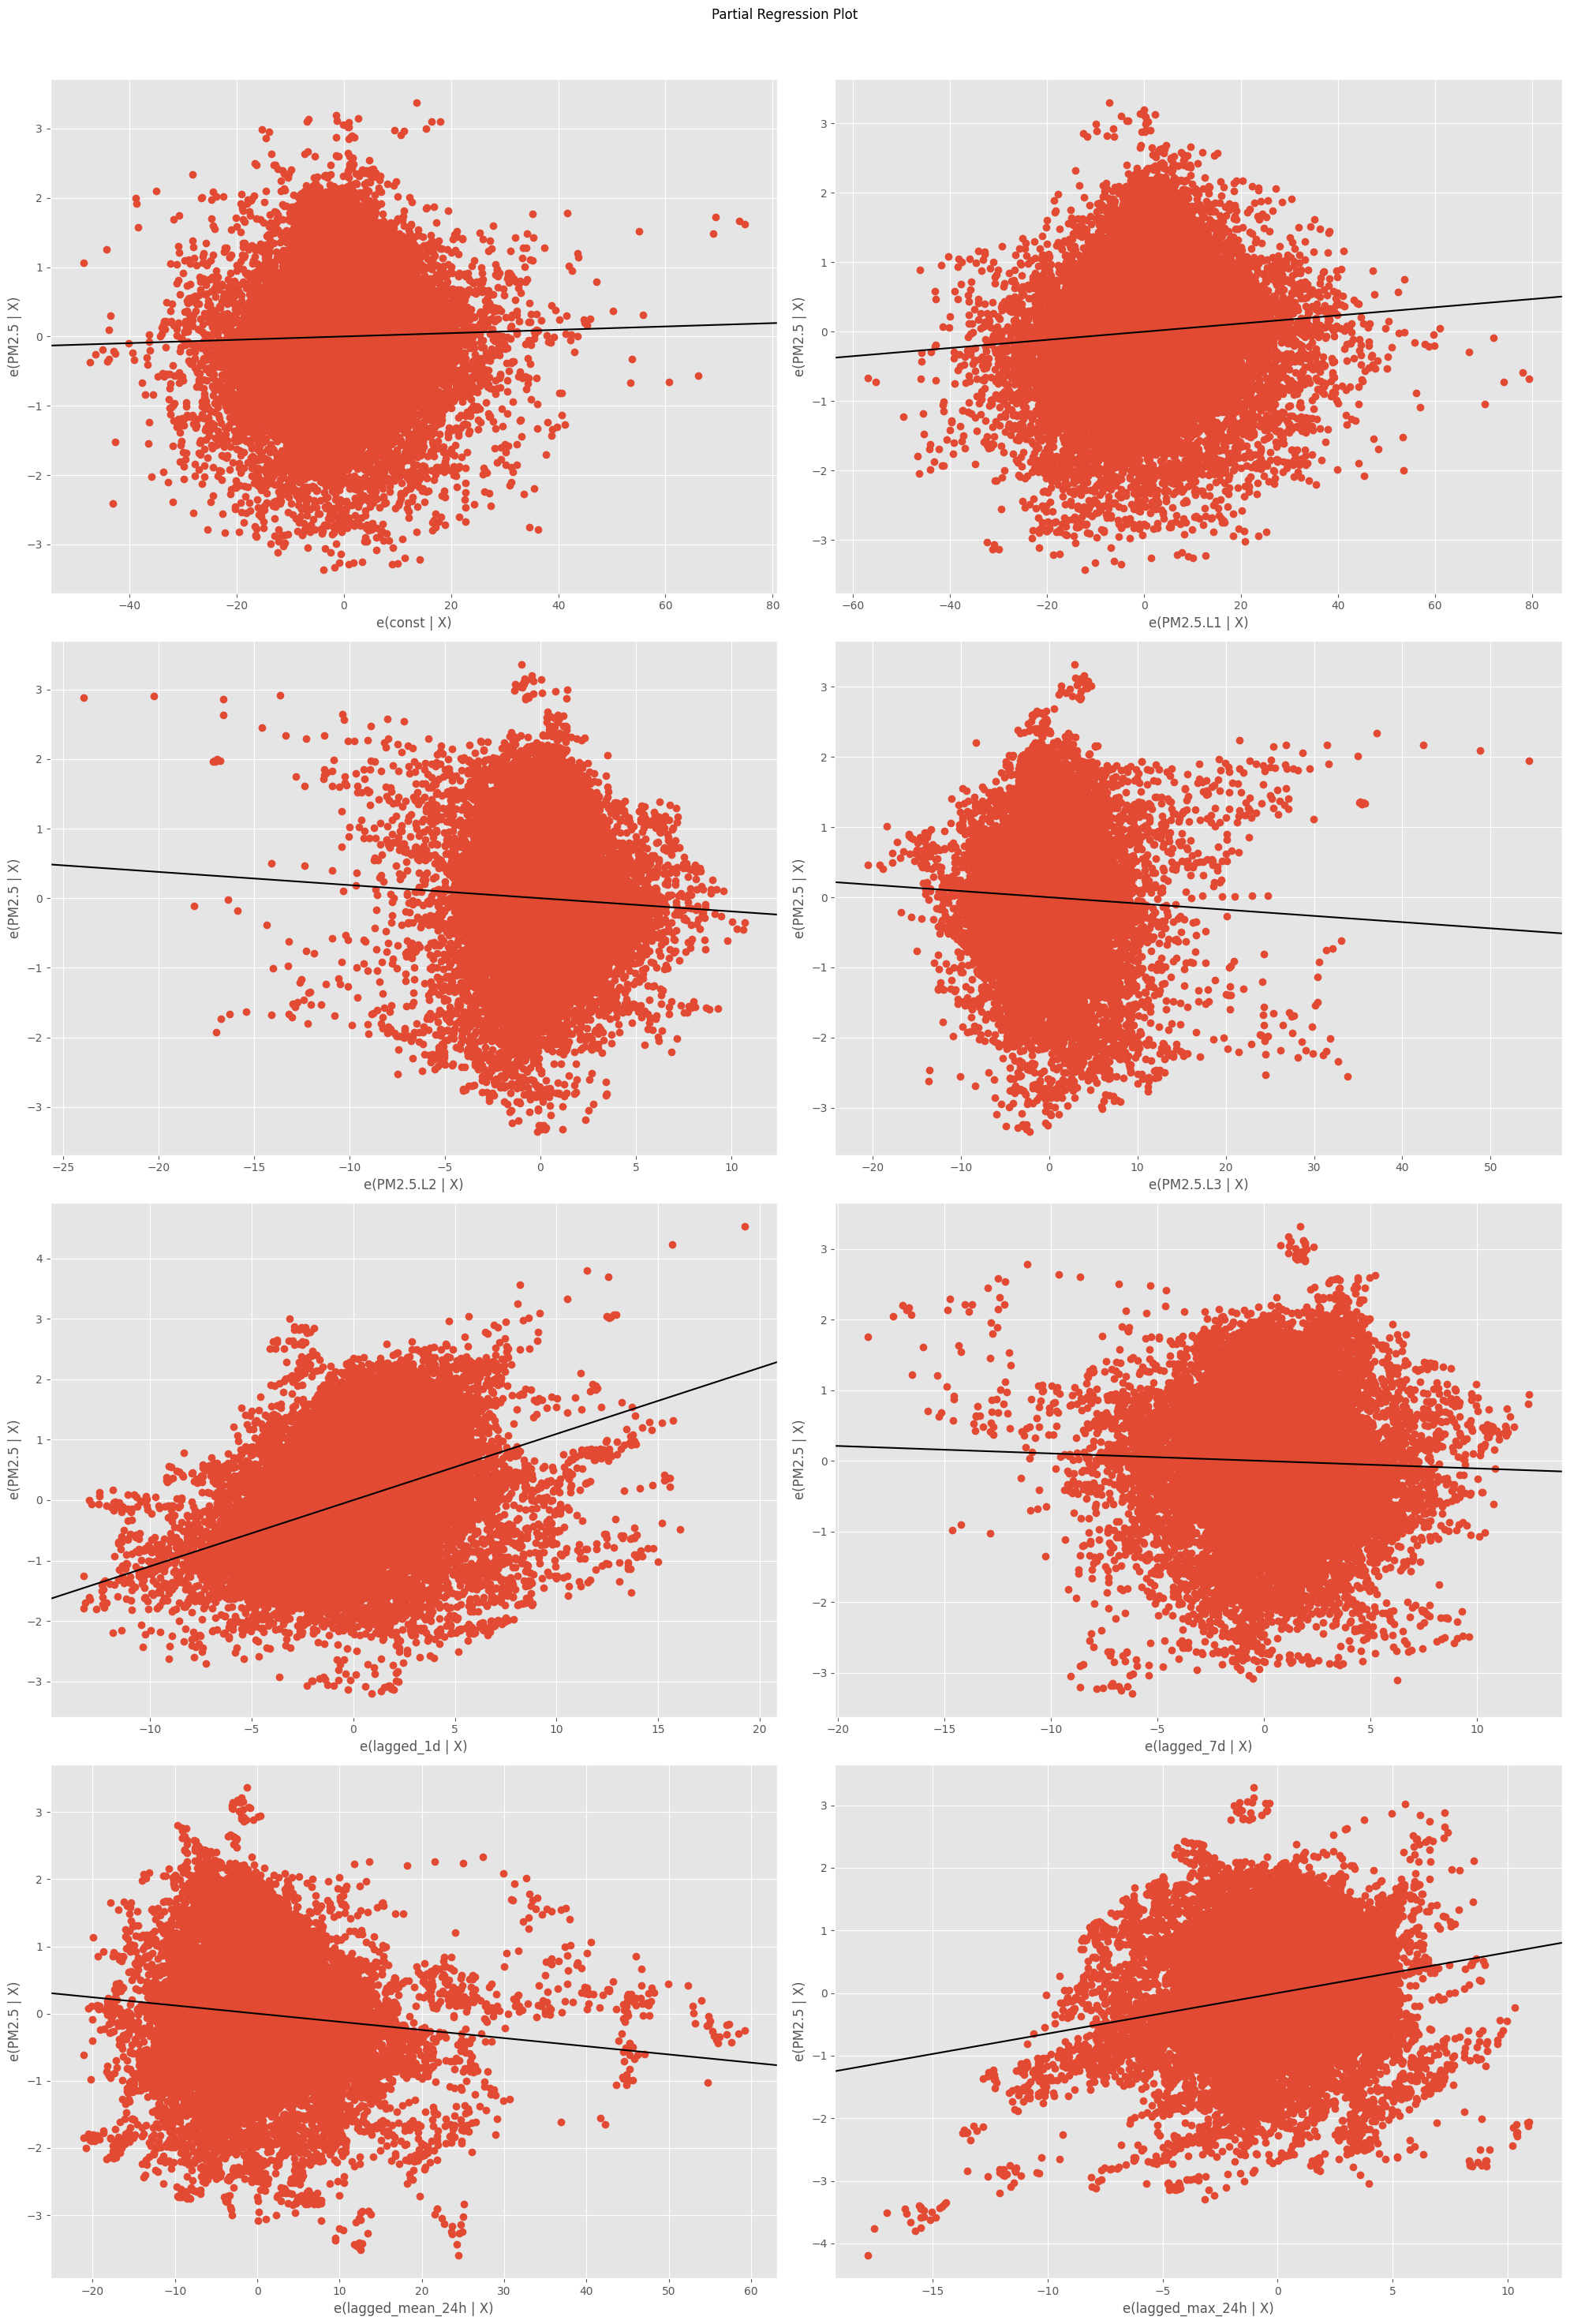

In [72]:
# Partial Regression Plot
plt.rcParams['figure.figsize']=(20,30)
fig = sm.graphics.plot_partregress_grid(AR_model)
print("Partial regression plot of AIR Pollution on features with AR model")
plt.show()

### Random Forest

Random Forest is a machine learning that belongs to the ensemble trees family. Ensemble methods work with the principle that a group of "weak learners" can come together to form a "strong learner". Each decision tree individually, is a "weak learner," while all the decision trees taken together are a "strong learner". A weak learner has a poorly performance, meanwhile a strong learner has a good score. Tree-based methods involve stratifying the feature space into a number of simple regions defined according to the explanatory variables and the splitting rules can be summarized in a tree view. The idea is to divide the feature space into distinct and non-overlapping regions. For every observation that falls into the region is made the same prediction, set as the region average, namely the mean of the response values for the training observations in the region. These regions could have any shape. The choice is to divide the feature space into high-dimensional rectangles with the goal to find rectangles that minimize the loss function, the residual sum of squares. Given it's computationally expensive to consider every possible partition of the feature space into regions is taken a top-down, greedy approach that is known as recursive binary splitting. Tree-based methods suffer of overfitting and Random Forest, introduced by Breiman in 2001, is able to fix the issue of high variance of trees.
It starts creating multiple copies of the original training data set using the bootstrapping, fits a decorrelated decision tree for each bootstrapped copy, and then average all of the trees in order to create a single predictive model. Moreover building these regression trees, each time for a split in a tree is considered a random selection of m predictors as split candidates from the full set of p predictors. The split is allowed to use only one of those m predictors.

In [73]:
# evaluation
RF = RandomForestRegressor(random_state=0)
evaluate(RF, X, np.log1p(y), cv=ts_cv)

Train evaluation
root_mean_squared_error: 0.031 ± 0.000
mean_absolute_error: 0.021 ± 0.000
Test evaluation
root_mean_squared_error: 0.075 ± 0.007
mean_absolute_error: 0.053 ± 0.003


In [74]:
# Prediction
RF_model = RF.fit(X_train, np.log1p(y_train))
rf_train = np.expm1(RF_model.predict(X_train))
rf_train_df = pd.DataFrame(rf_train, columns=['PM2.5_train'])
rf_test = np.expm1(RF_model.predict(X_test))
rf_test_df = pd.DataFrame(rf_test, columns=['PM2.5_test'])

In [75]:
# Build a dataframe with actual and predicted values
df1 = rf_train_df.transpose().reset_index(drop=True).transpose()
df2 = rf_test_df.transpose().reset_index(drop=True).transpose()
dfs = [df1,df2]
df_ = pd.concat(dfs,axis=0,ignore_index=True)
dfs_= df_.rename(columns= {0:'PM2.5_estimation'})
df_RF_fin = pd.concat([df_lag['PM2.5'], dfs_.set_index(df_lag.index)], axis=1)

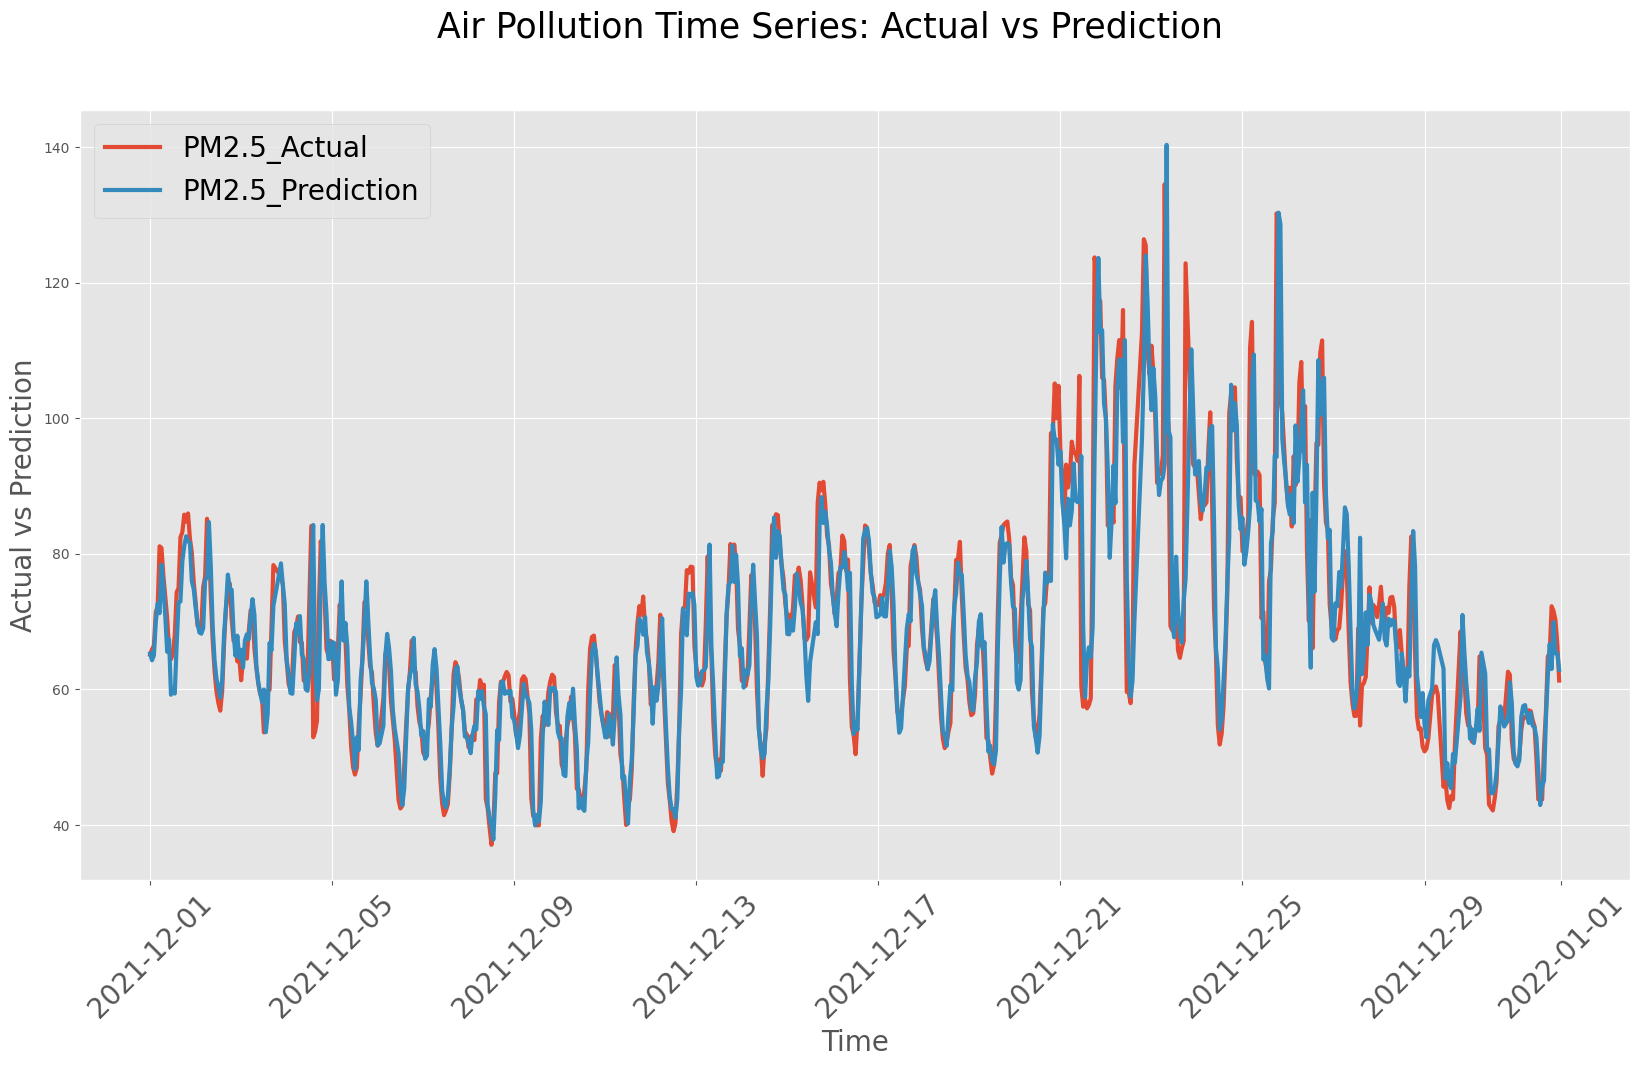

In [76]:
# Plot results on a period year
tsmultiplot(df_RF_fin,period='2021-12')
plt.show()

In [77]:
# Features Importance
print('RF Features Permutation Importance')
RF_perm = PermutationImportance(RF_model, random_state=0).fit(X_test, np.log1p(y_test))
eli5.show_weights(RF_perm, feature_names = X_test.columns.tolist())


RF Features Permutation Importance


Partial dependence of AIR Pollution on features with RF model


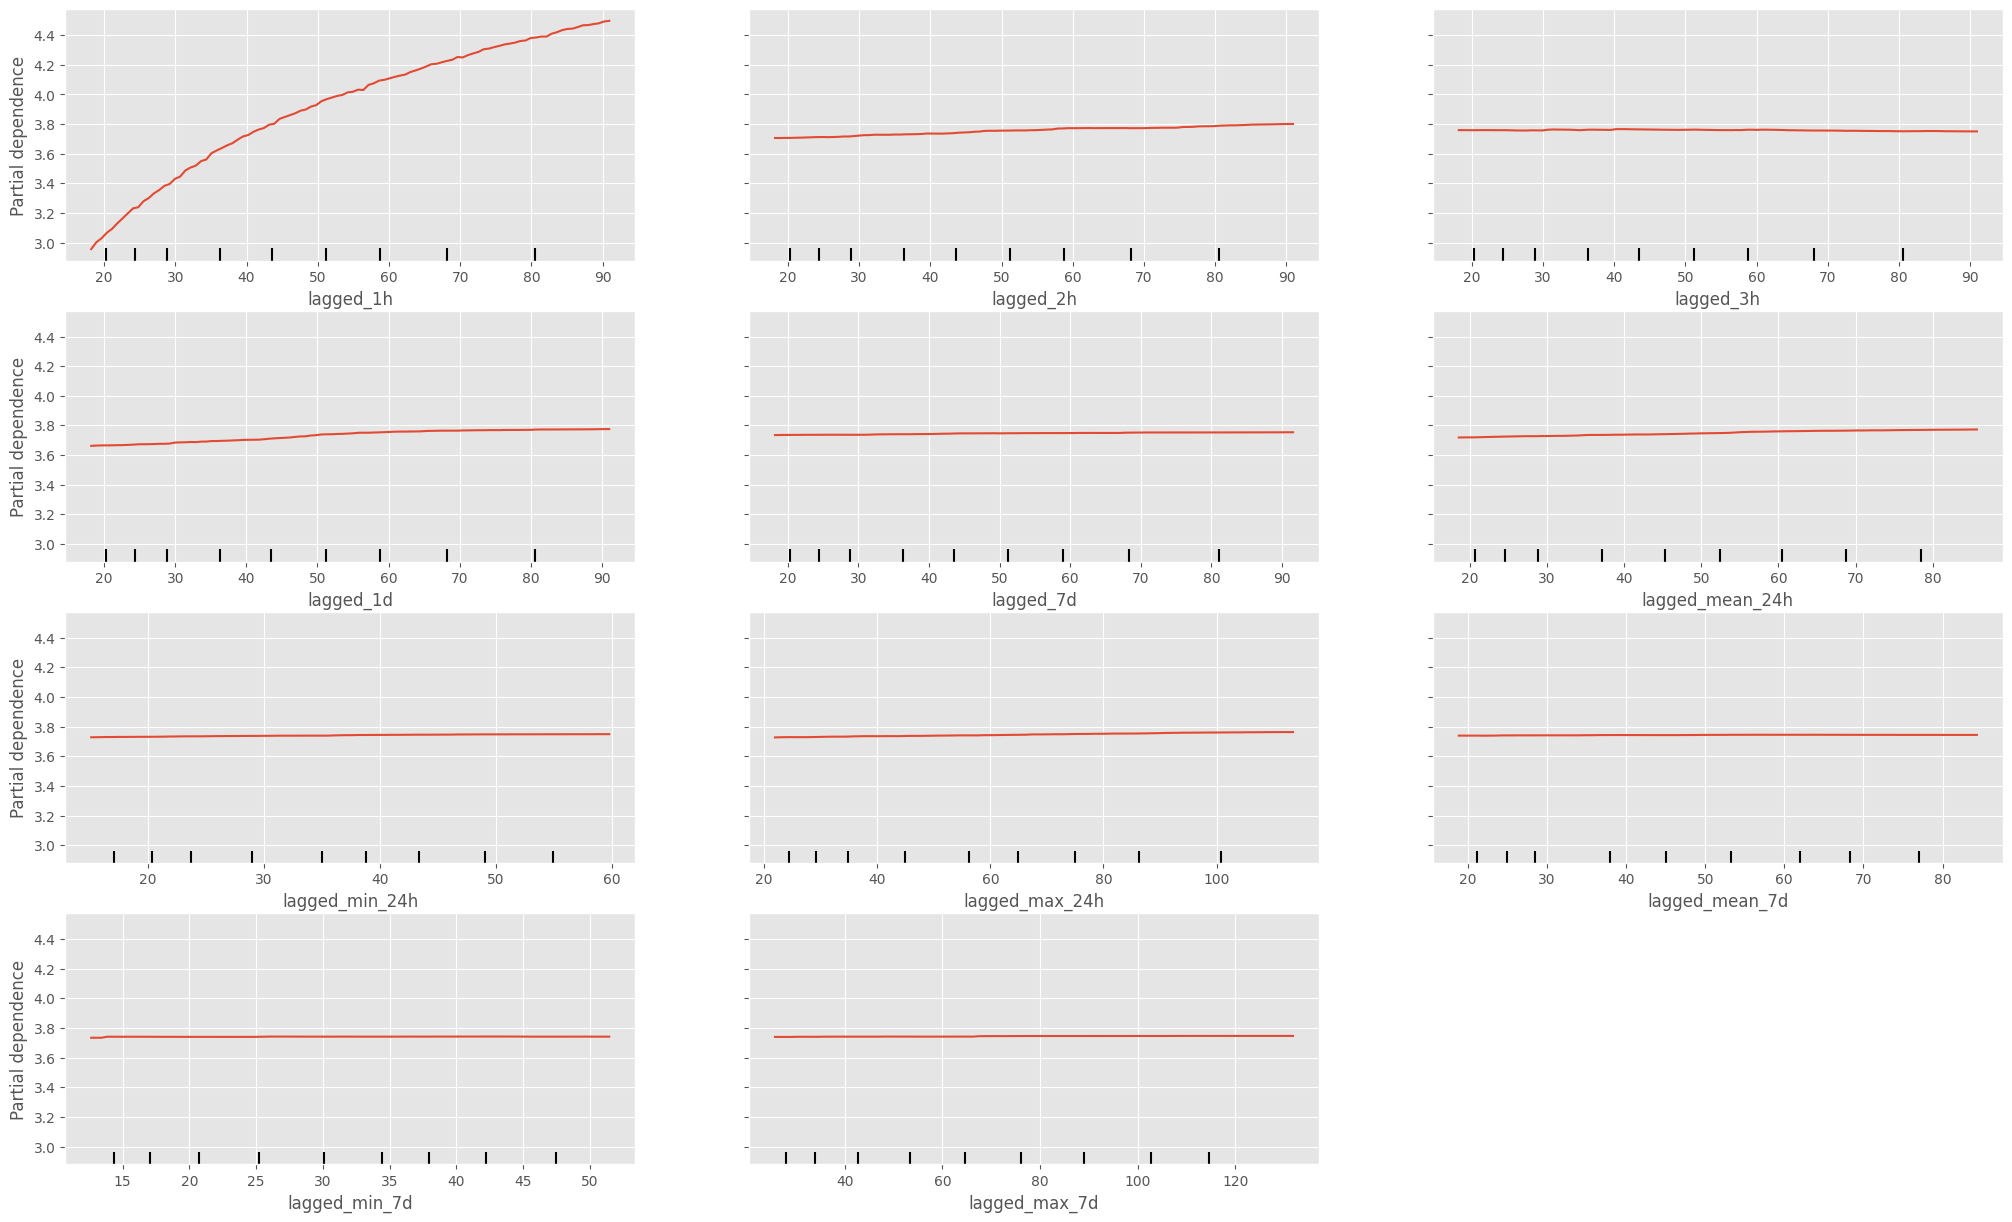

In [78]:
# Partial Dependence Plot
plt.rcParams['figure.figsize']=(25,15)
PartialDependenceDisplay.from_estimator(RF_model,X,
['lagged_1h','lagged_2h', 'lagged_3h','lagged_1d','lagged_7d',
 'lagged_mean_24h','lagged_min_24h','lagged_max_24h',
 'lagged_mean_7d','lagged_min_7d','lagged_max_7d'],  
                                        kind='average', random_state=0)
print("Partial dependence of AIR Pollution on features with RF model")
plt.show()

### Explainable Boosting Machine

Another supervised learning approach is coming from the Explainable Boosting Machine that is a result of the combination of high performance by ensemble trees and interpretability by Generalized Additive Models (GAMs). The Explainable Boosting Machine is an extension of the Generalized Additive Models into two directions: 
-fits each function by a combination of modern machine learning models like bagging and boosting; 
-detects and fits pairwise relationships functions between variables. 
The function associated at each predictor is generated by many small trees trained with a Gradient Boosting in an iterative way for each feature one after another with a low learning rate ensuring that the model is additive, and each shape function uses only one feature at time. Once a model is trained with individual features, a second step is run with the same training process, but looking at pairs of features. After these steps, all the trees produced for a single feature are used to predict the training samples building the function linked at each predictor, and the same for pairs of features. The mentioned Boosting, introduced by Jerome Friedman, is an alternative method of bagging for building an ensemble trees. Bagging as well as Random forest are built on a large number of trees, combined using averages at the end of the process while Gradient Boosting Machine also combine regression trees, but it starts combining process at the beginning. It works sequentially, fitting a model based on the residuals from the previous models, in this way the model is able to focus in areas where previous trees have performed more poorly.

In [79]:
# Evaluation
EBM = ExplainableBoostingRegressor(random_state=0)
evaluate(EBM, X, np.log1p(y), cv=ts_cv)

Train evaluation
root_mean_squared_error: 0.085 ± 0.000
mean_absolute_error: 0.060 ± 0.000
Test evaluation
root_mean_squared_error: 0.081 ± 0.006
mean_absolute_error: 0.060 ± 0.003


In [80]:
# Prediction
EBM_model = EBM.fit(X_train, np.log1p(y_train))
ebm_train = np.expm1(EBM_model.predict(X_train))
ebm_train_df = pd.DataFrame(ebm_train, columns=['PM2.5_train'])
ebm_test = np.expm1(EBM_model.predict(X_test))
ebm_test_df = pd.DataFrame(ebm_test, columns=['PM2.5_test'])

In [81]:
# Build a dataframe with actual and predicted values
df1 = ebm_train_df.transpose().reset_index(drop=True).transpose()
df2 = ebm_test_df.transpose().reset_index(drop=True).transpose()
dfs = [df1,df2]
df_ = pd.concat(dfs,axis=0,ignore_index=True)
dfs_= df_.rename(columns= {0:'PM2.5_estimation'})
df_EBM_fin = pd.concat([df_lag['PM2.5'], dfs_.set_index(df_lag.index)], axis=1)

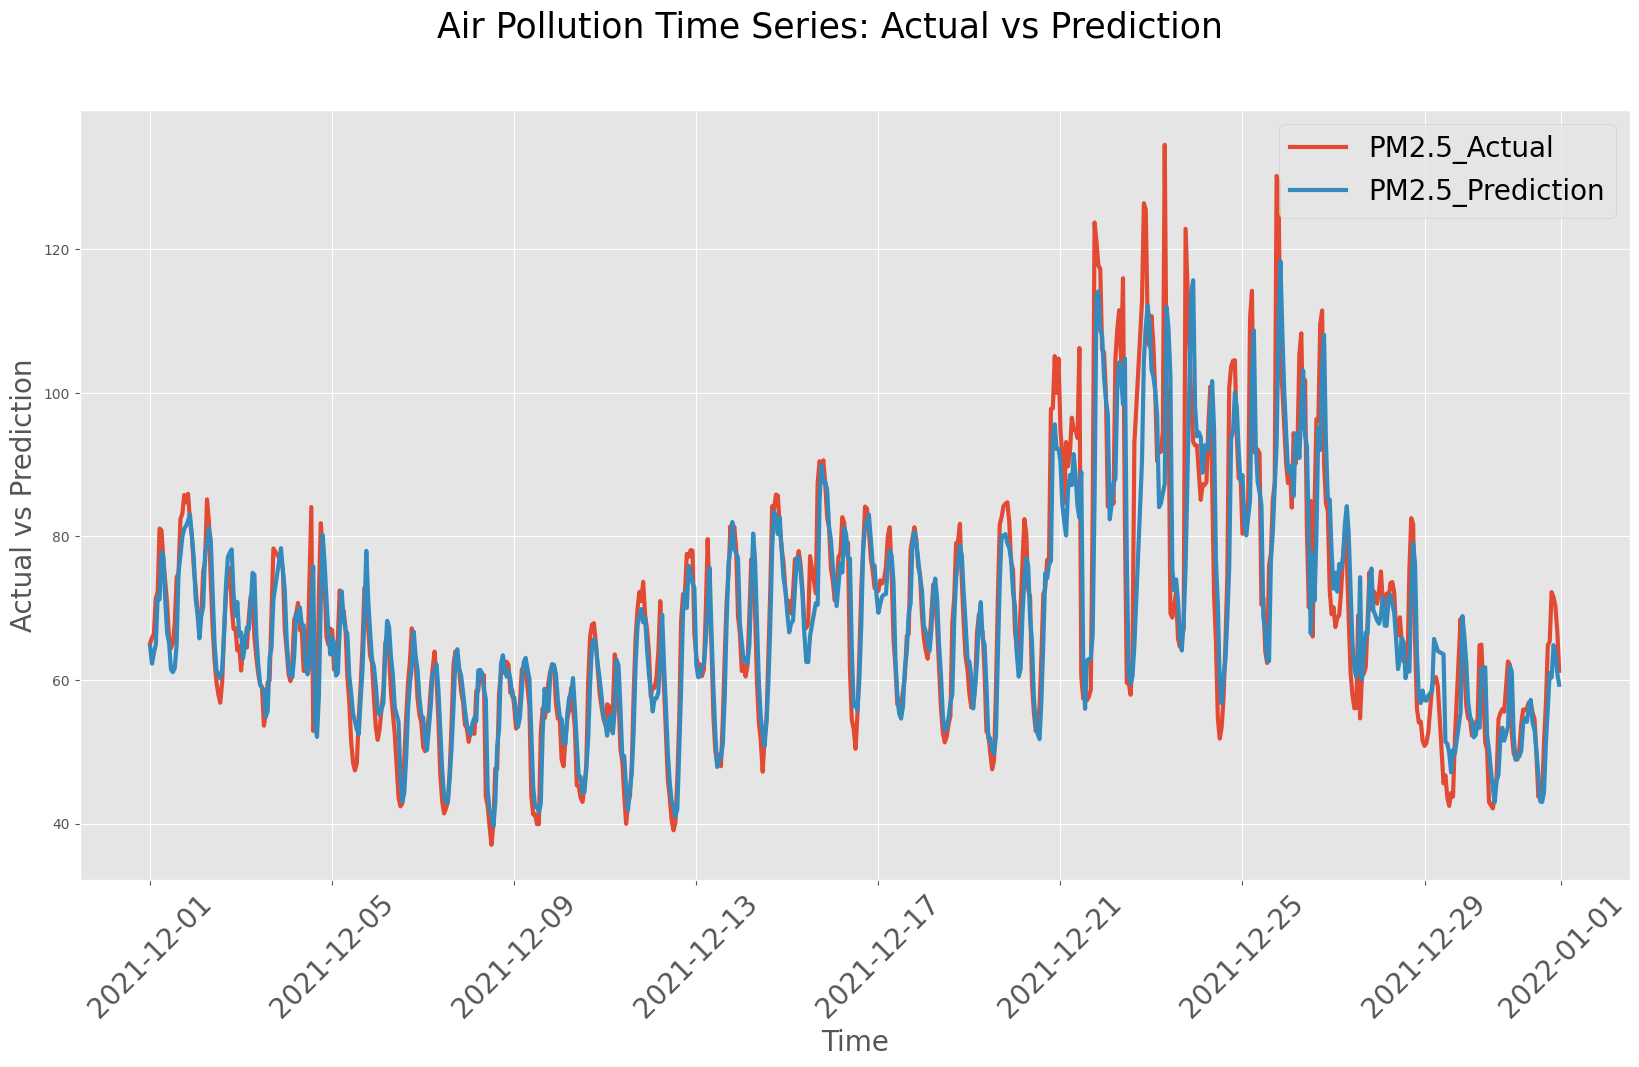

In [82]:
# Plot results on a time period
tsmultiplot(df_EBM_fin,period='2021-12')
plt.show()

In [83]:
# Features Importance
print('EBM Features Permutation Importance')
EBM_perm = PermutationImportance(EBM_model, random_state=0).fit(X_test, np.log1p(y_test))
eli5.show_weights(EBM_perm, feature_names = X_test.columns.tolist())

EBM Features Permutation Importance


Partial dependence of AIR Pollution on features with EBM model


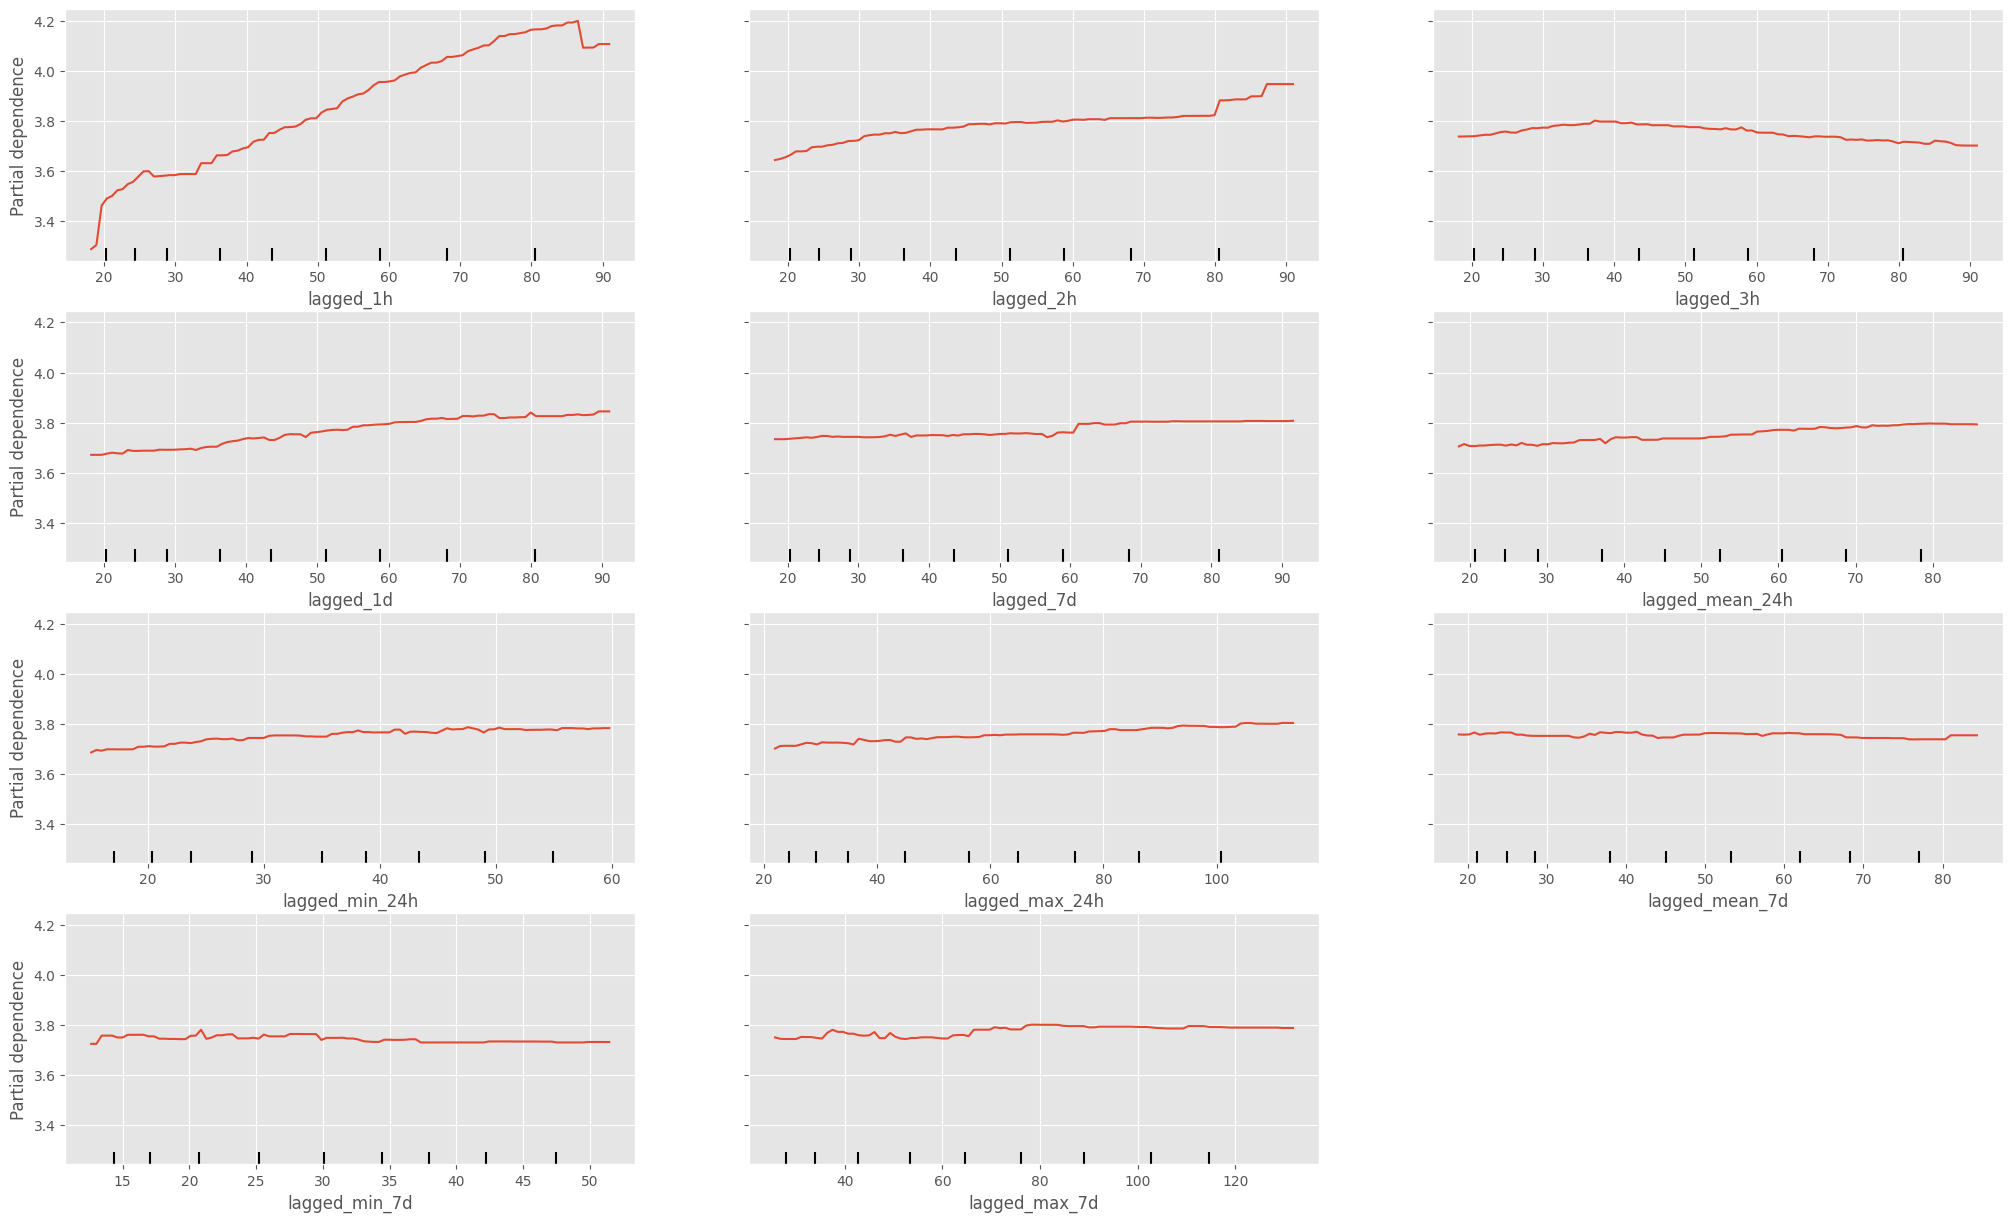

In [84]:
# Partial Dependence Plot
plt.rcParams['figure.figsize']=(25,15)
PartialDependenceDisplay.from_estimator(EBM_model,X,
['lagged_1h','lagged_2h', 'lagged_3h','lagged_1d','lagged_7d',
 'lagged_mean_24h','lagged_min_24h','lagged_max_24h',
 'lagged_mean_7d','lagged_min_7d','lagged_max_7d'], 
                                        kind='average', random_state=0)
print("Partial dependence of AIR Pollution on features with EBM model")
plt.show()

### Neural Networks

Neural Networks are inspired by neuroscience, they are formed by neurons
connected in various ways. Neuron is the basic building block of the Neural Networks.
Each neuron represents a simple computational unit that has weighted input signals and produce an output signal using an activation function. Neurons are stacked into networks to create complex architectures. A row of neurons is called a layer and one network can have multiple layers. In every layer there is a linear combination of weights and input features or latent features coming from preceding layers and
then is applied an activation function extending linear models. Artificial Neural Networks have an input layer with as many neurons as the number of explanatory variables. The input layer is followed by one or several hidden layers with an optional number of neurons. The number of neurons in the output layer equals the number of dependent variables. These type of models are called feed-forward because information flows in one direction, from the input, through the hidden layers, and to the output. 

In [85]:
scaling = MinMaxScaler()

In [86]:

X_sc= pd.DataFrame(scaling.fit_transform(X),columns= ['lagged_1h','lagged_2h','lagged_3h',
                                                     'lagged_1d','lagged_7d','lagged_mean_24h',
                                                    'lagged_max_24h','lagged_min_24h','lagged_mean_7d',
                                                    'lagged_max_7d','lagged_min_7d'])
X_train_sc= pd.DataFrame(scaling.fit_transform(X_train),columns= ['lagged_1h','lagged_2h','lagged_3h',
                                                     'lagged_1d','lagged_7d','lagged_mean_24h',
                                                    'lagged_max_24h','lagged_min_24h','lagged_mean_7d',
                                                    'lagged_max_7d','lagged_min_7d'])
X_test_sc= pd.DataFrame(scaling.fit_transform(X_test),columns= ['lagged_1h','lagged_2h','lagged_3h',
                                                     'lagged_1d','lagged_7d','lagged_mean_24h',
                                                    'lagged_max_24h','lagged_min_24h','lagged_mean_7d',
                                                    'lagged_max_7d','lagged_min_7d'])
y_sc = scaling.fit_transform(pd.DataFrame(y).values.reshape(-1,1))
y_train_sc = scaling.fit_transform(pd.DataFrame(y_train).values.reshape(-1,1))
y_test_sc = scaling.fit_transform(pd.DataFrame(y_test).values.reshape(-1,1))



In [87]:
# evaluation
NN = MLPRegressor(hidden_layer_sizes=(15), activation='relu', solver='adam', max_iter=500,random_state=0)
evaluate(NN, X_sc, np.log1p(y_sc), cv=ts_cv)

Train evaluation
root_mean_squared_error: 0.022 ± 0.000
mean_absolute_error: 0.015 ± 0.000
Test evaluation
root_mean_squared_error: 0.022 ± 0.006
mean_absolute_error: 0.015 ± 0.003


In [88]:
# Prediction
NN_model = NN.fit(X_train_sc, np.log1p(y_train_sc))
nn_train = np.expm1(NN_model.predict(X_train_sc))
nn_train=scaling.inverse_transform(nn_train.reshape(-1,1))
nn_train_df = pd.DataFrame(nn_train, columns=['PM2.5_train'])
nn_test = np.expm1(NN_model.predict(X_test_sc))
nn_test=scaling.inverse_transform(nn_test.reshape(-1,1))
nn_test_df = pd.DataFrame(nn_test, columns=['PM2.5_test'])

In [89]:
# Build a dataframe with actual and predicted values
df1 = nn_train_df.transpose().reset_index(drop=True).transpose()
df2 = nn_test_df.transpose().reset_index(drop=True).transpose()
dfs = [df1,df2]
df_ = pd.concat(dfs,axis=0,ignore_index=True)
dfs_= df_.rename(columns= {0:'PM2.5_estimation'})
df_NN_fin = pd.concat([df_lag['PM2.5'], dfs_.set_index(df_lag.index)], axis=1)

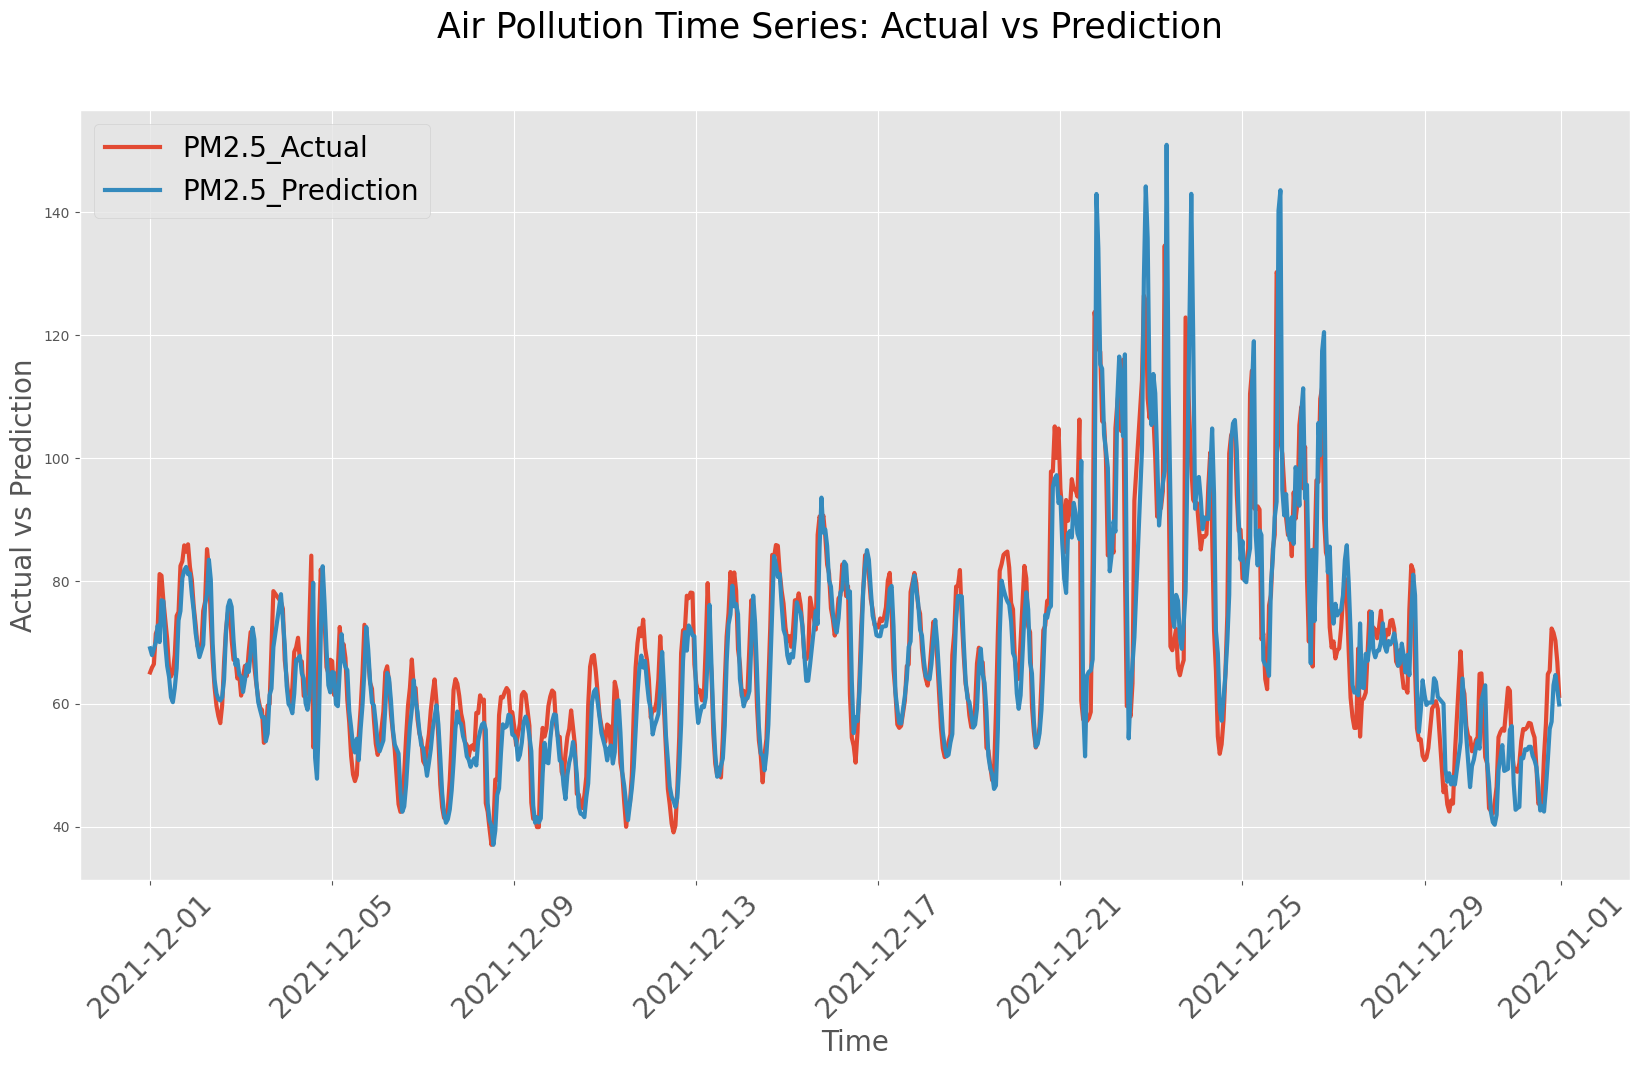

In [90]:
# Plot results on a period year
tsmultiplot(df_NN_fin,period='2021-12')
plt.show()

In [91]:
# Features Importance
print('NN Features Permutation Importance')
NN_perm = PermutationImportance(NN_model, random_state=0).fit(X_test_sc, np.log1p(y_test_sc))
eli5.show_weights(NN_perm, feature_names = X_test.columns.tolist())

NN Features Permutation Importance


Partial dependence of AIR Pollution on features with NN model


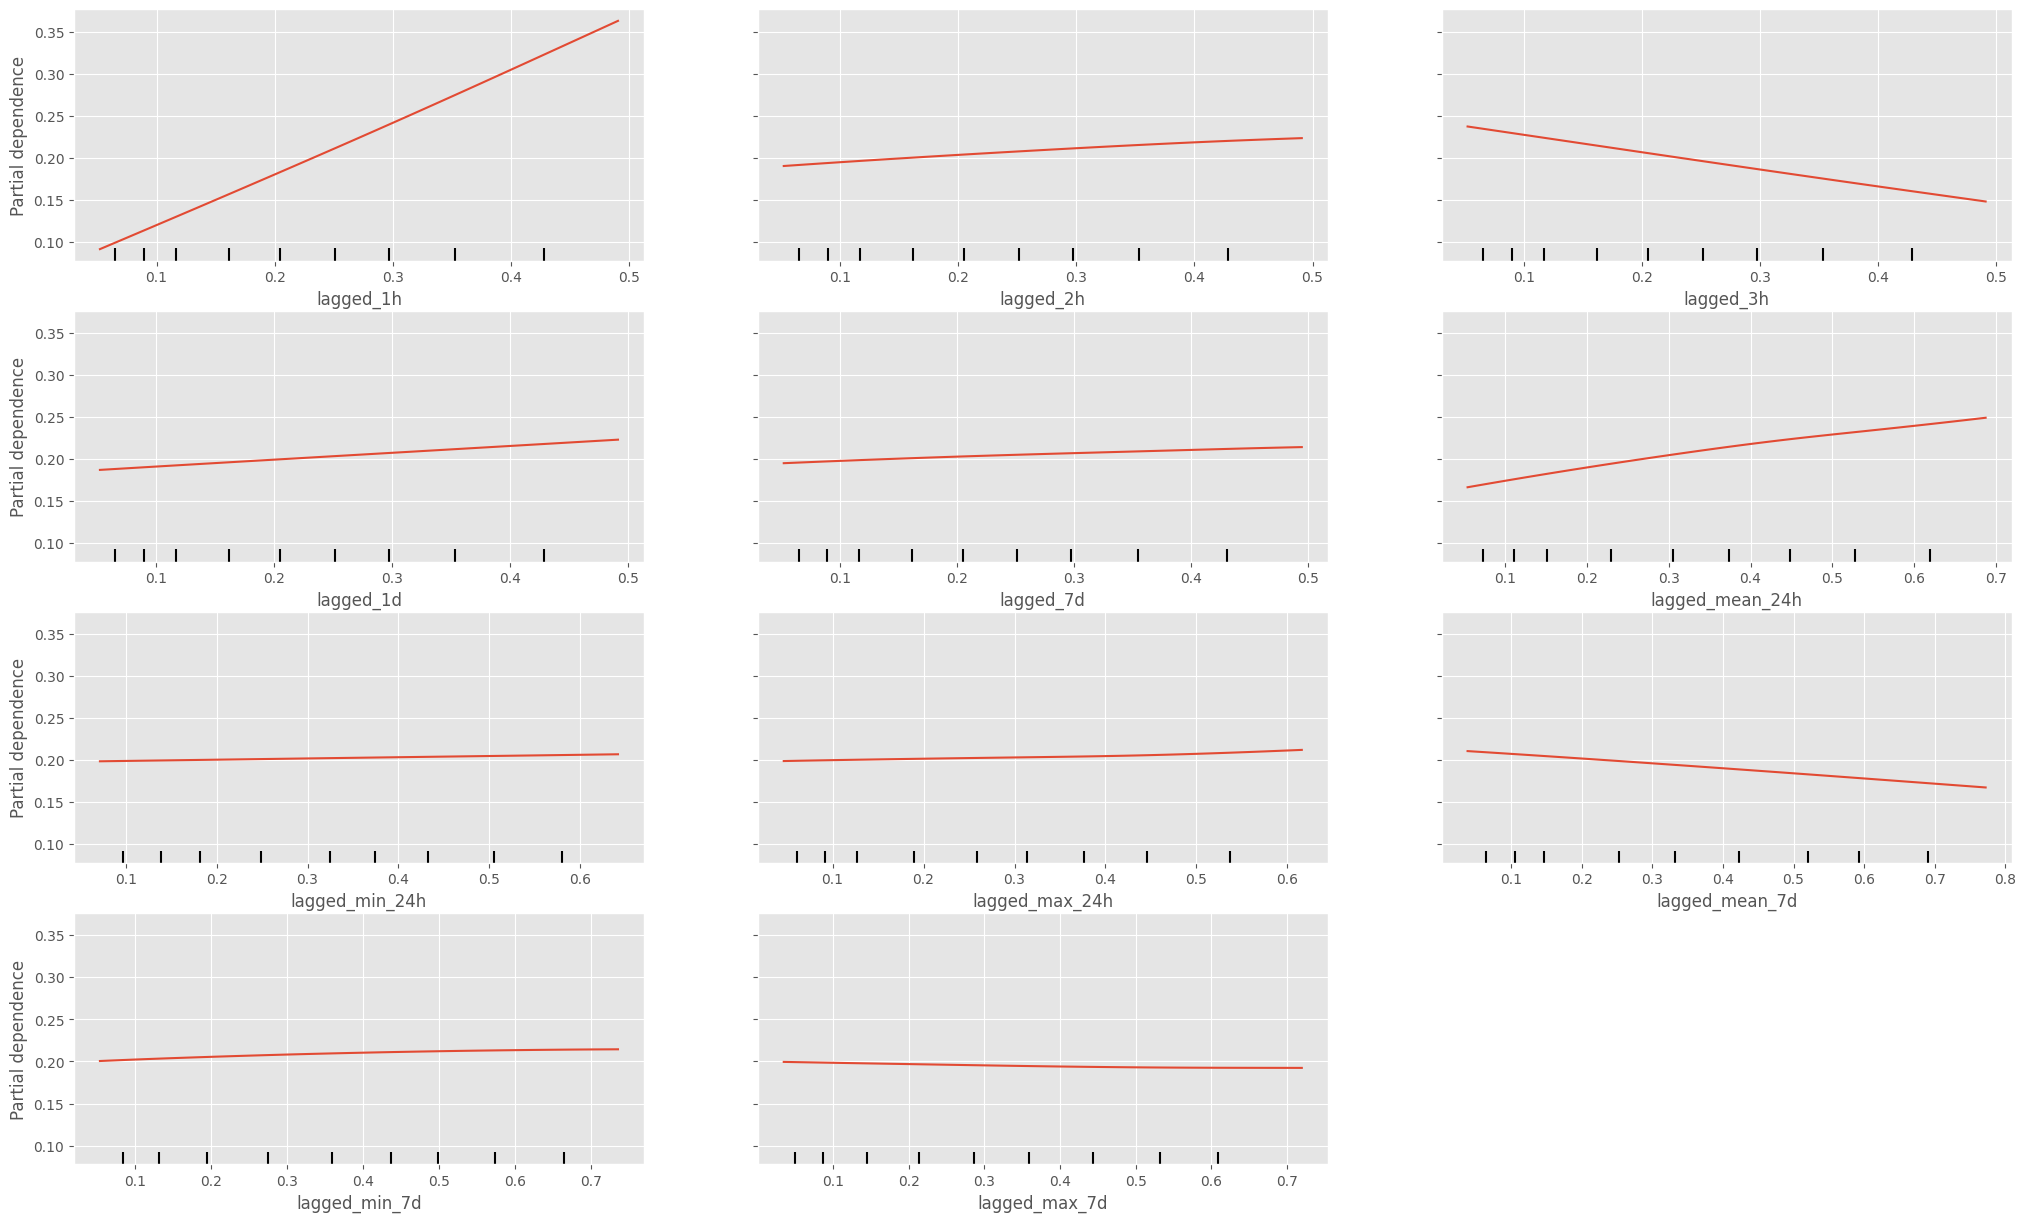

In [92]:
# Partial Dependence Plot
plt.rcParams['figure.figsize']=(25,15)
PartialDependenceDisplay.from_estimator(NN_model,X_sc,
['lagged_1h','lagged_2h', 'lagged_3h','lagged_1d','lagged_7d',
 'lagged_mean_24h','lagged_min_24h','lagged_max_24h',
 'lagged_mean_7d','lagged_min_7d','lagged_max_7d'], 
                                        kind='average', random_state=0)
print("Partial dependence of AIR Pollution on features with NN model")
plt.show()

From the analysis Neural Networks seems to be the best performing model. The Autoregressive
model, as a benchmark, shows poor result. Random Forest and Explainable Boosting Machine follow in a good way shape of observations, but the previous one overfit. Neural Networks are able to capture spikes in the observations following the shape of observations.
In all models the lag feature shifted by an hour is the most relevant to explain the outcome, the others change depending by the model. From the Partial Dependence Plot there is a confirm about the positive correlation between the ”lagged 1h” feature and the air pollution.
